# 1d polynya growth model

https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/JC092iC07p07049

In [641]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import calendar
from calendar import monthrange

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
from matplotlib.ticker import MultipleLocator

import matplotlib.dates as mdates

# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy import img_transform

from metpy.units import units


# path to own functions
sys.path.append('../../')
import timeseries.adjust as tseries
import geofunc.general as geogen
import geofunc.vectors as vectors
import geofunc.shapes as geoshape

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [642]:
# Save to file
df = pd.read_csv('../data/constants.csv')
df = df.set_index('var')
df

cst = {}
for variable in list(df.index):
    cst[variable] = df.loc[variable]['value'] * units(df.loc[variable]['units'])
    
cst

{'Cp_o': <Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>,
 'Cp_a': <Quantity(1004.0, 'joule / kilogram / delta_degree_Celsius')>,
 'sigma_sb': <Quantity(5.670367e-08, 'watt / meter ** 2 / kelvin ** 4')>,
 'rho_a': <Quantity(1.225, 'kilogram / meter ** 3')>,
 'rho_o': <Quantity(1028.0, 'kilogram / meter ** 3')>,
 'rho_i': <Quantity(917.0, 'kilogram / meter ** 3')>,
 'L_i': <Quantity(334000.0, 'joule / kilogram')>,
 'k_i': <Quantity(2.2, 'watt / meter / delta_degree_Celsius')>,
 'kappa': <Quantity(0.4, 'dimensionless')>,
 'St': <Quantity(0.0057, 'dimensionless')>,
 'omega': <Quantity(7.2921e-05, 'radian / second')>}

In [643]:
ua = 8 * units('m/s')
va = 3 * units('m/s')
Ta = -5 *units('degC')
Xpmax, t95 = Pease_Model(ua, va, Ta, 
                         wf = 0.02,  Hi = 10 * units('cm'))

print(Xpmax, t95)

54.443335539981064 kilometer 11.814959969613946 day


In [644]:
def Pease_Model(ua, va, Ta, wf = 0.02,  Hi = 25 * units('cm')):
    
    def convert_to_k(T):
    
        if T.units == 'degree_Celsius':
            T = T.to('degree_Kelvin')
        elif T.units == 'delta_degree_Celsius':
            print('T!! should not be delta deg C')
        return T

    def find_Qlu(Tw, sigma, eo):
        Tw = convert_to_k(Tw)
        qlu = sigma * eo * Tw**4
        return qlu.to('W/m2')


    def find_Qld(Ta, sigma, ea):
        Ta = convert_to_k(Ta)
        qld = sigma * ea * Ta**4
        return qld.to('W/m2')


    def find_Qs(Ta, Tw, rho_a, Cpa, Va):

        Ta = Ta.magnitude * units('delta_degree_Celsius')
        Tw = Tw.magnitude * units('delta_degree_Celsius')

        Ch = 2e-3 # sensible heat coefficient

        qs = rho_a * Ch * Cpa * Va * (Ta-Tw)

        return qs.to('W/m2')


    # ua : east wind (m/s) 
    # va : north wind (m/s) 
    # Ua : wind speed (m/s)

    # constants
    Tw = -1.8 * units('degC')

    # variables from ERA5
    sa = np.sqrt(ua**2+va**2)

    # ice drift rate
    Vi = wf * ua.to('cm/s').to('km/day')

    # define positive upward
    Qlu = find_Qlu(Tw, cst['sigma_sb'], 0.98)
    Qld = -find_Qld(Ta, cst['sigma_sb'], 0.95)
    Qs = -find_Qs(Ta, Tw, cst['rho_a'], cst['Cp_a'], sa)

    # new ice growth rate from heat balance
    Qnet = Qlu + Qld + Qs
    Fi = (Qnet / (cst['L_i'] * cst['rho_i'])).to('cm/hour')
    
    # limiting width
    Xpmax = (Vi * Hi / Fi).to('km')
    
    # time to reach 95% of limiting size
    t95 = (3 * Hi / Fi).to('day')
     
    return Xpmax, t95

In [645]:
def xp_over_time_iter(Vi, t, Fi, Hi = 1 * units('m')):

    Xp = np.array([0]) * units('km')
    
#     Xip = np.append(0*units('km'), np.cumsum((Vi[:-1].to(f'km/{time_unit}'))*np.diff(t)))
    
#     Xip = (np.cumsum(Vi.to('km/hour'))).to('km')
    
    for tt in range(len(t)-1):
        
        Xp_tm1 = Xp[-1].to('km')
        
        dt = (t[tt+1] - t[tt]).to('hour')
        dXp = ((Vi[tt] - Xp_tm1 * Fi[tt] / Hi) * dt).to('km')
        
        Xp_t = dXp + Xp_tm1
        
        Xp = np.append(Xp, Xp_t)
        
    return Xp
        
        
    
    
    
def xp_over_time(Vi, t, Fi, Hi = 1 * units('m')):
    
    # Hi : frazil ice collection depth
    
    C = - Vi * Hi / Fi
    Xp = - C * (1 - np.exp(-t * Fi / Hi))
    Xp = Xp.to('km')
    Xi = (Vi*t).to('km')
    
#     # time to reach 95% of limiting size
#     t95 = 3 * Hi/Fi

    return Xp, Xi 




def convert_to_k(T):
    
    if T.units == 'degree_Celsius':
        T = T.to('degree_Kelvin')
    elif T.units == 'delta_degree_Celsius':
        print('T!! should not be delta deg C')
    return T
        
def find_Qlu(Tw, sigma, eo):
    Tw = convert_to_k(Tw)
    qlu = sigma * eo * Tw**4
    return qlu.to('W/m2')


def find_Qld(Ta, sigma, ea):
    Ta = convert_to_k(Ta)
    qld = sigma * ea * Ta**4
    return qld.to('W/m2')


def find_Qs(Ta, Tw, rho_a, Cpa, Va):
    
    Ta = Ta.magnitude * units('delta_degree_Celsius')
    Tw = Tw.magnitude * units('delta_degree_Celsius')
    
    Ch = 2e-3 # sensible heat coefficient

    qs = rho_a * Ch * Cpa * Va * (Ta-Tw)
    
    return qs.to('W/m2')


from metpy.calc import saturation_mixing_ratio, mixing_ratio_from_relative_humidity, relative_humidity_from_dewpoint
import gsw


def find_Qe(Pa, Ta, Tw, Td, rho_a, Va, Sa, Ct):
    
    Le = gsw.latentheat_evap_CT(Sa,Ct) * units('J/kg')
    
    Ta = Ta.magnitude * units('degree_Celsius')
    Tw = Tw.magnitude * units('degree_Celsius')
    Td = Td.magnitude * units('degree_Celsius')
    
    rh = relative_humidity_from_dewpoint(Ta, Td)
    qa = mixing_ratio_from_relative_humidity(Pa, Ta, rh).to('g/kg')  # mixing ratio at Ta
    qs = saturation_mixing_ratio(Pa, Tw).to('g/kg')                  # saturated mixing ratio at Tw
    
    Ce = 2e-3 # latent heat coefficient
    
    qe = (rho_a * Ce * Le * Ua * (qa-qs))

    return qe.to('W/m2')


<IPython.core.display.Javascript object>


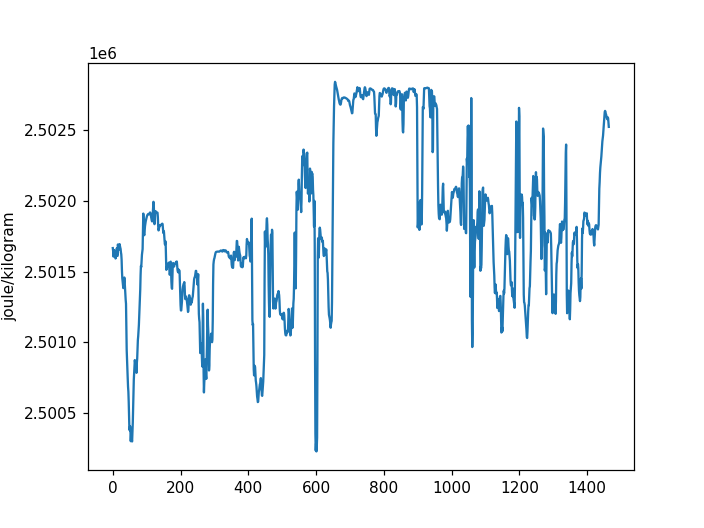

In [436]:
import gsw
# Le = gsw.latentheat_evap_CT(32*units('g/kg').magnitude, -1*units('degC').magnitude) * units('J/kg')
# Le

Le = gsw.latentheat_evap_CT(dso.Sa.sel(depth=-16).values, 
                            dso.Ct.sel(depth=-16).values*units('degC').magnitude) * units('J/kg')
# dso.Ct.sel(depth=-16).values
fig, ax= plt.subplots()
plt.plot(Le)

In [420]:
cst

# Le = 2260*1000 * units('J/kg')

(Le/cst['L_i'])


<Quantity(7.48804911, 'dimensionless')>

<IPython.core.display.Javascript object>


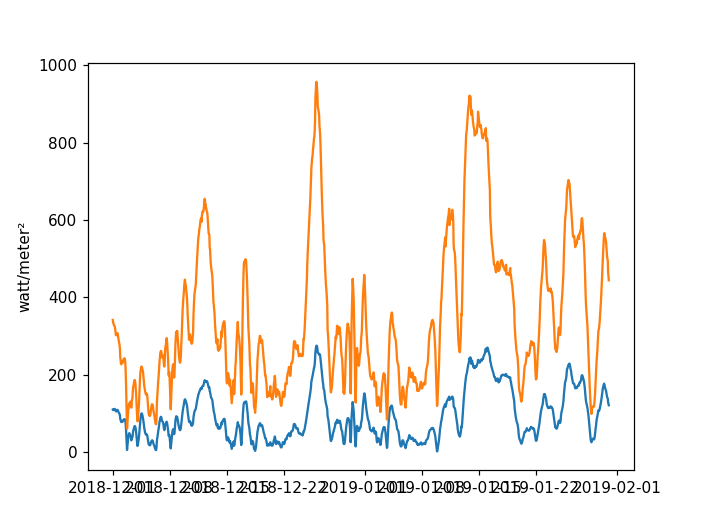

In [452]:

fig, ax= plt.subplots()
# plt.plot(Ta, Qe)
plt.plot(ds.time, Qe)
plt.plot(ds.time, Qnet)


In [178]:
qs

<Quantity([3.51297022 3.51233496 3.51283258 ... 3.45733287 3.45723447 3.45824417], 'gram / kilogram')>

In [751]:

# time_range = slice(datetime(2024,1,2), datetime(2024,1,17))

# time_range = slice(datetime(2019,1,13), datetime(2019,1,25))

# time_range = slice(datetime(2016,1,13), datetime(2016,1,25))

# time_range = slice(datetime(2018,1,1), datetime(2018,1,21))


# time_range = slice(datetime(2016,12,15), datetime(2016,12,28))
# open_years = '2016_2017'


# time_range = slice(datetime(2019,1,13,0), datetime(2019,1,30))
# open_years = '2018_2019'

# time_range = slice(datetime(2017,12,22), datetime(2017,12,28))
# open_years = '2017_2018'


# time_range = slice(datetime(2017,12,1), datetime(2017,12,31))
# open_years = '2017_2018'


# time_range = slice(datetime(2016,12,1), datetime(2017,4,30))
# open_years = '2016_2017'


# time_range = slice(datetime(2018,1,1), datetime(2018,4,1))
# open_years = '2017_2018'


time_range = slice(datetime(2017,12,1), datetime(2018,4,30))
open_years = '2017_2018'

# time_range = slice(datetime(2018,12,1,0), datetime(2019,1,31))
# open_years = '2018_2019'


# time_range = slice(datetime(2016,12,5), datetime(2016,12,10))


# time_range = slice(datetime(2019,12,7), datetime(2019,12,20))


## Ocean conditions

In [752]:
dsc = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_ocean_currents_{open_years}.nc')
dsc.close()
dsc = dsc.sel(time=time_range)
dsc_dma = dsc.mean('depth')

dsi = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_seaice_velocity_{open_years}.nc')
dsi.close()
dsi = dsi.sel(time=time_range).sel(depth=0)

dso = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_tempsalinity_{open_years}.nc')
dso.close()
dso = dso.sel(time=time_range)




dso = dso.interpolate_na(dim='time', method='linear')

Tw_sfc = dso.sel(depth=-16).T.values *units('degC')
Tf_sfc = dso.sel(depth=-16).Tf.values *units('degC')

# Tw_sfc = dso.sel(depth=-16).T.interp(time=pd.date_range(time_range.start, time_range.stop, freq='1H'), 
#                                   method="linear").values *units('degC')
# Tf_sfc = dso.sel(depth=-16).Tf.interp(time=pd.date_range(time_range.start, time_range.stop, freq='1H'), 
#                                   method="linear").values *units('degC')


Tw_dma = dso.mean('depth').T.values *units('degC')
Tf_dma = dso.mean('depth').Tf.values *units('degC')
sig0_dma = (dso.mean('depth').sig0.values+1000) *units('kg/m3')



In [753]:
100 * units('km/day').to('m/s')

<Quantity(1.15740741, 'meter / second')>

### Open polynya heat transport estimate

In [754]:
ds = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/regridded/M1_OHT_{open_years}_v0.nc')
ds.close()

ds = ds.sel(time=time_range)

# mean_dt = (ds.CT-ds.Tf).mean('z')
# DT = (ds.CT-ds.Tf) * units('delta_degC')

mean_dt = (ds.dT).mean('z')
DT = (ds.dT) * units('delta_degC')

mean_sig = ds.sig0.mean('z')
SIG = ds.sig0 * units('kg/m3')
U = vectors.comp_along_theta(ds.u, ds.v, 145*units('degree'))* units('m/s')

# U = np.clip(vectors.comp_along_theta(ds.u, ds.v, 145*units('degree')), 0, 1.2)* units('m/s')

ht_perm3 = cst['Cp_o']*DT*SIG*U
hc_perm3 = cst['Cp_o']*DT*SIG
dz = ds.z.diff('z').values[0] * units('m')

IHT = 0.5*np.sum(ht_perm3[:-1, :].values + ht_perm3[1:, :].values, axis=0) *units('joule/m2/s') * dz
IHC = 0.5*np.sum(hc_perm3[:-1, :].values + hc_perm3[1:, :].values, axis=0) *units('joule/m3') * dz

hc_event = hc_perm3.sel(time=time_range)
IHC_event = 0.5*np.sum(hc_event[:-1, :].values + hc_event[1:, :].values, axis=0) *units('joule/m3') * dz



<IPython.core.display.Javascript object>


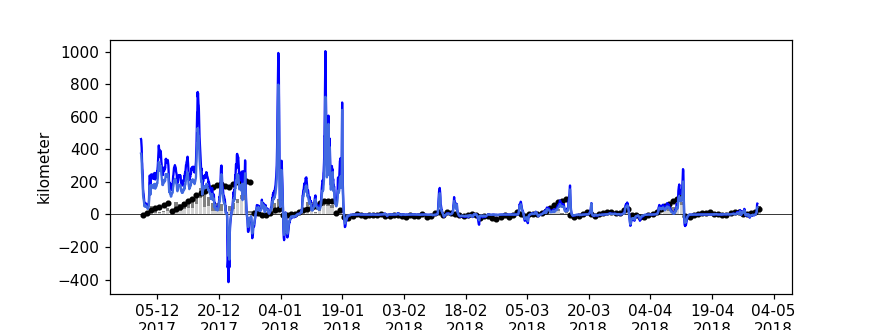

In [769]:
fig, ax = plt.subplots(figsize=(8,3))

# plt.plot(ds.time, (IHC_event/Qnet).to('day'))

# plt.plot(ds.time, (IHC_event/Qnet).to('day'), c='b')
# plt.plot(ds.time, (IHC_event/Qnet_with_Qe).to('day'), c='royalblue')

plt.plot(ds.time, (IHC_event/Qnet).to('day') * U.mean('z').values * units('m/s').to('km/day'), c='b')
plt.plot(ds.time, (IHC_event/Qnet_with_Qe).to('day') * U.mean('z').values * units('m/s').to('km/day'), c='royalblue')

plt.bar(pd.to_datetime(DS.time)+timedelta(hours=12), DS.l_max.values, color='gray')
plt.bar(pd.to_datetime(DS.time)+timedelta(hours=12), DS.bulk_length.values, color='lightgray')
plt.scatter(pd.to_datetime(DS.time)+timedelta(hours=12),cum_ese10, c='k', marker='.')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
date_fmt = mdates.DateFormatter('%d-%m\n%Y')
ax.xaxis.set_major_formatter(date_fmt)

plt.axhline(0, c='k', lw=0.5, zorder=-1)
# fig.savefig('/Users/mackenziejewell/Desktop/cooling_rate_2018.png', dpi=300, bbox_inches='tight')

<IPython.core.display.Javascript object>


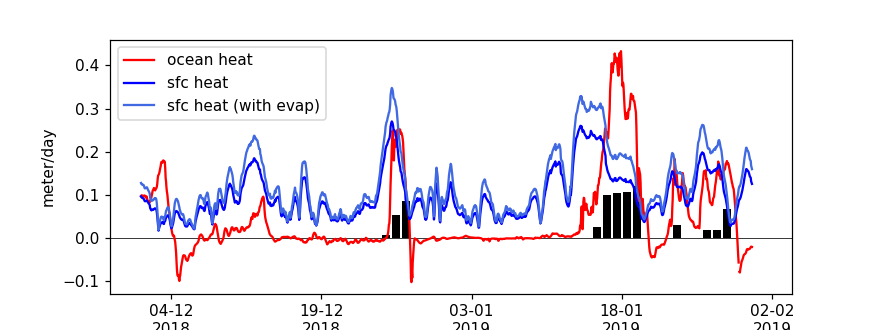

In [721]:
fig, ax = plt.subplots(figsize=(8,3))


# plt.plot(IHC / (cst['L_i']*cst['rho_o']))
# plt.plot(ds.time, (IHT * curr_w / (cst['L_i']*cst['rho_i'])).to('km3/day'))

plt.bar(pd.to_datetime(DS.time)+timedelta(hours=12), DS.l_max.values/1000, color='k')

plt.plot(ds.time, (IHT / (cst['L_i']*cst['rho_i'])).to('m2/day') / (shelf_l), c='r', label='ocean heat')
plt.plot(ds.time, Qnet / (cst['L_i']*cst['rho_i']), c='b', label='sfc heat')
plt.plot(ds.time, Qnet_with_Qe / (cst['L_i']*cst['rho_i']), c='royalblue', label='sfc heat (with evap)')

plt.legend()


ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
date_fmt = mdates.DateFormatter('%d-%m\n%Y')
ax.xaxis.set_major_formatter(date_fmt)
# plt.plot(ds.time[U.mean('z')>0.2], IHC[U.mean('z')>0.2] / (cst['L_i']*cst['rho_i']))

plt.axhline(0, c='k', lw=0.5, zorder=-1)

# fig.savefig('/Users/mackenziejewell/Desktop/energy_balance_2019.png', dpi=300, bbox_inches='tight')

<IPython.core.display.Javascript object>


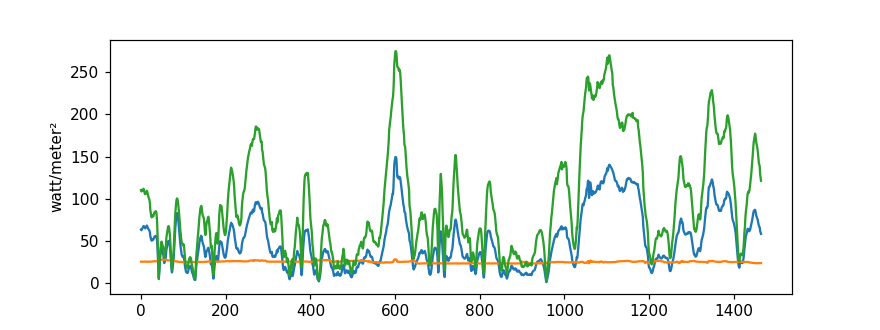

In [675]:
fig, ax = plt.subplots(figsize=(8,3))
plt.plot(Qs)
plt.plot(Qlu+Qld)
plt.plot(Qe)

In [667]:
Qld

<Quantity(-278.513326, 'watt / meter ** 2')>

In [672]:
Qnet = Qlu + Qld + Qs
Qnet_with_Qe = Qlu + Qld + Qs + Qe

In [ ]:
plt.plot()

In [660]:
cst['L_i']

<Quantity(334000.0, 'joule / kilogram')>

<IPython.core.display.Javascript object>


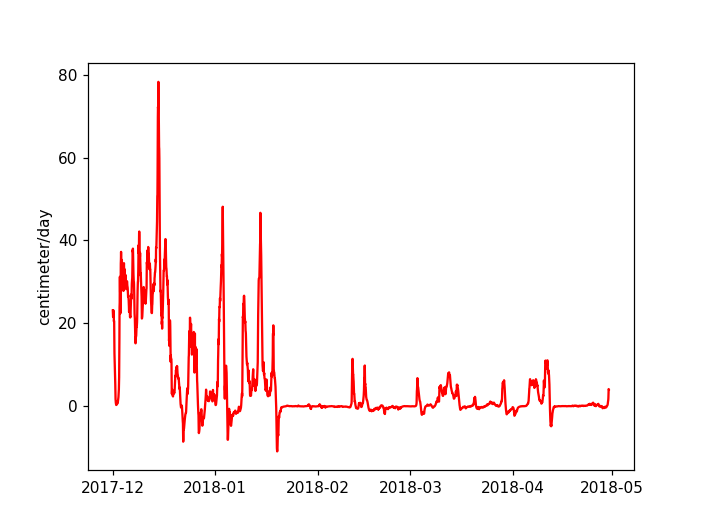

ValueError: x and y must have same first dimension, but have shapes (3601,) and (1465,)

In [755]:
fig, ax = plt.subplots()

curr_w = 30 * units('km').to('m')

shelf_w = 30 * units('km').to('m')
shelf_l = 100 * units('km').to('m')

# plt.plot(ds.time, curr_w * IHT / (shelf_w * shelf_l) - Qnet)

# plt.plot(ds.time, curr_w * IHT / (shelf_w * shelf_l) )

plt.plot(ds.time, ((curr_w * IHT / (shelf_w * shelf_l) ) / (cst['L_i'] * cst['rho_i'])).to('cm/day'), c='r')

# plt.plot(ds.time, Qnet)
# plt.plot(ds.time, Qnet_with_Qe * hourly_lengths)
# plt.plot(IHT2 / 10e8)


# plt.plot(ds.time, ((Qnet*hourly_extents/(shelf_w * shelf_l))/ (cst['L_i'] * cst['rho_i'])).to('cm/day'))

# plt.plot(ds.time, (Qnet_with_Qe/ (cst['L_i'] * cst['rho_i'])).to('cm/day'))
plt.plot(ds.time, (Qnet/ (cst['L_i'] * cst['rho_i'])).to('cm/day'), c='b')

plt.plot(ds.time, (Qnet *(hourly_lengths/shelf_l)/ (cst['L_i'] * cst['rho_i'])).to('cm/day'), c='dodgerblue')

plt.bar(pd.to_datetime(DS.time)+timedelta(hours=12), DS.l_max.values, color='darkgray')
plt.bar(pd.to_datetime(DS.time)+timedelta(hours=12), DS.bulk_length.values, color='lightgray')
plt.scatter(pd.to_datetime(DS.time)+timedelta(hours=12),cum_ese10, c='k')
# plt.plot(DS.time,cum_esei, c='k', marker='*')
# plt.plot(DS.time,df_ese10)

### Open polynya length estimate

In [764]:


with xr.open_dataset(f'../data/polynya_size/daily_polynya_{time_range.stop.year}_sic10_v7.4_radius25km.nc') as DS:

    DS = DS.sel(time = slice(time_range.start - timedelta(days=1), time_range.stop))

    DS['t'] = ((DS.time.values - DS.time.values[0]) / np.timedelta64(1, 's')) * units('s').to('hour')
    
    ds_times = pd.to_datetime(ds.time.values)
    
    
time_cond = (ds_times>=(time_range.start - timedelta(days=1))) & (ds_times<=time_range.stop)


interp_times = pd.date_range(time_range.start - timedelta(days=1), time_range.stop, freq='1H')

hourly_extent = DS.extent.interp(time=interp_times, method="linear").values[12:-12]
hourly_extents = hourly_extent * units('km2').to('m2')

DS['width595'] = (DS.w_per95 - DS.w_per5) + 6.25
DS['bulk_length'] = DS.extent/DS.width595
hourly_length = (DS.bulk_length).interp(time=interp_times, method="linear").values[12:-12]

# hourly_length = (DS.l_max+6.25/2).interp(time=interp_times, method="linear").values[12:-12]
# hourly_length = (DS.l_max-DS.l_min+6.25).interp(time=interp_times,method="linear").values[12:-12]
hourly_lengths = hourly_length * units('km').to('m')

DS = DS.sel(time = time_range)

<IPython.core.display.Javascript object>


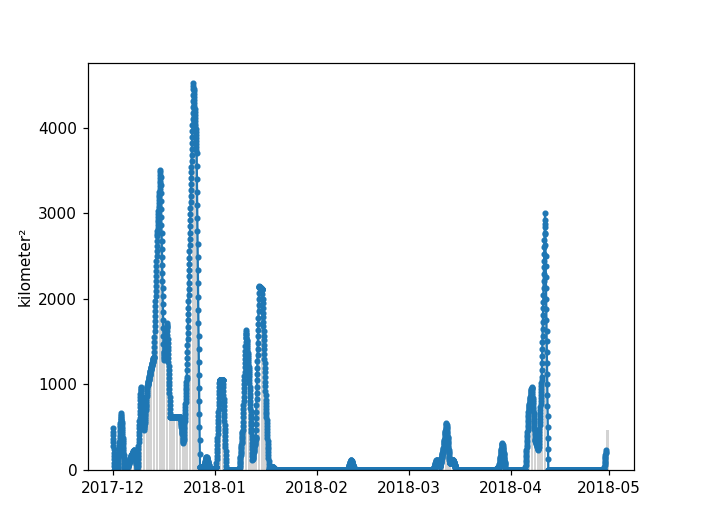

<BarContainer object of 151 artists>

In [765]:
fig, ax= plt.subplots()
plt.plot(ds.time, hourly_extents.to('km2'), marker='.')
plt.bar(pd.to_datetime(DS.time) + timedelta(hours=12), DS.extent.values, color='lightgray')

In [758]:
# time_range = slice(datetime(2019,1,13,0), datetime(2019,1,25))
# open_years = '2018_2019'


In [766]:
df2 = pd.read_csv('../data/compiled_stats.csv')

df2['esei'] = vectors.comp_along_theta(df2['ui'], df2['vi'], 165*units('degree')) * units('cm/s').to('km/day')
df2['ese10'] = 0.02*vectors.comp_along_theta(df2['u10'], df2['v10'], 180*units('degree'))* units('m/s').to('km/day')


df_times = pd.to_datetime(df2.time)
during_event = (df_times>=time_range.start)&(df_times<=time_range.stop)
df_time = df2.time[during_event].values
df_esei = df2.esei[during_event].values
df_ese10 = df2.ese10[during_event].values


seqs = list(set(df2.sequence[during_event&(df2.sequence!=-999)].values))
cum_ese10 = np.copy(df_ese10)
cum_esei = np.copy(df_esei)

for ss in seqs:
    
    during = np.where(df2.sequence[during_event] == ss)[0]
    
    
    
    
    cum_ese10[during[0]-1:during[-1]+1] = np.cumsum(cum_ese10[during[0]-1:during[-1]+1])
    cum_esei[during[0]-1:during[-1]+1] = np.cumsum(cum_esei[during[0]-1:during[-1]+1])
    
#     for ii in range()

# manually modify this for now since I set too strict of threshold


<IPython.core.display.Javascript object>


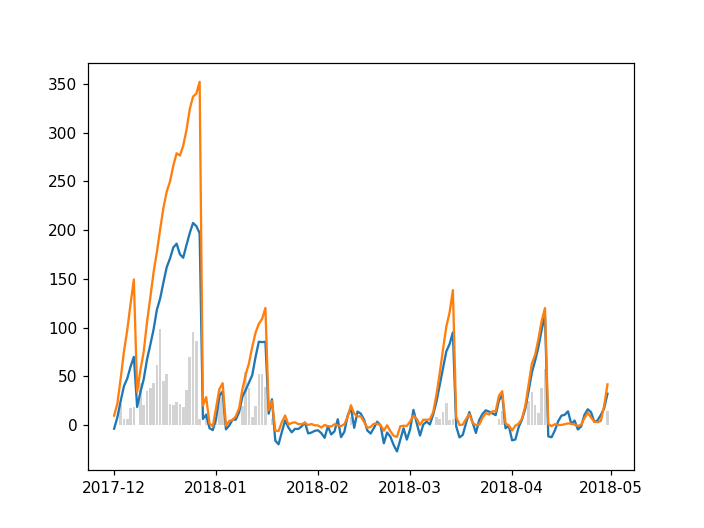

<BarContainer object of 151 artists>

In [767]:
fig, ax = plt.subplots()
plt.plot(DS.time,cum_ese10)
plt.plot(DS.time,cum_esei)
# plt.plot(DS.time,df_ese10)

plt.bar(DS.time, DS.bulk_length.values, color='lightgray')

<IPython.core.display.Javascript object>


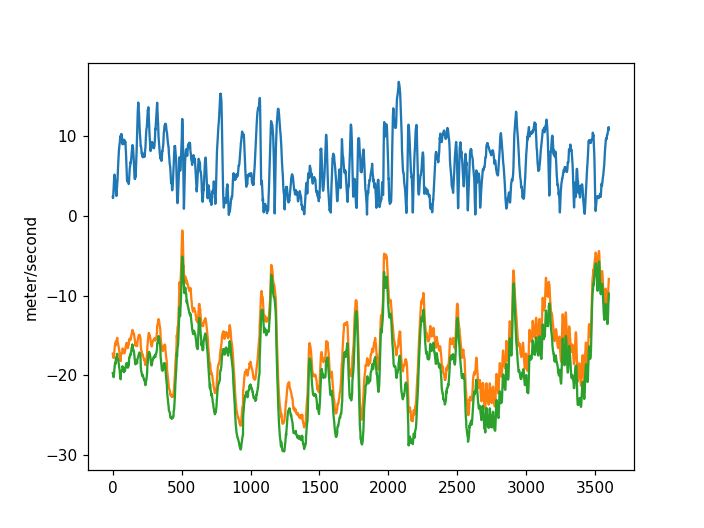

In [761]:
# dl = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/ERA5/hourly_t2m/ERA5_T2m_hourly_{time_range.stop.year}.nc')
# Ta = (dl.sel(latitude=70, longitude=-139.75, valid_time = time_range).t2m.values - 273.15) * units('degC')


# dw = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_{time_range.stop.year}.nc')
# dw = dw.sel(latitude=70, longitude=-139.75, time = time_range)
dw = xr.open_dataset(f'../data/forcing/regional_hourly_era_{time_range.stop.year}_v7_witht2m.nc')
dw = dw.sel(time = time_range)
Ua = np.sqrt(dw.u10.values**2+dw.v10.values**2) * units('m/s')
Ta = (dw.t2m.values-273.15) * units('degC')
Td = (dw.d2m.values-273.15) * units('degC')
Pa = dw.msl.values * units('Pa').to('hPa')

ua_ice_drift = -0.025 * dw.u10.values * units('m/s').to('km/hour')

fig, ax= plt.subplots()
plt.plot(Ua)
plt.plot(Ta.magnitude)
plt.plot(Td.magnitude)


In [762]:

# Tw = dso.T.sel(depth=-16).values * units('degC')

# Twater = dso.T.mean('depth').values * units('degC')

# Twater = np.full(len(Ta), -1.8) * units('degC')
Twater = Tw_sfc

# Tair = Ta_HI
# Uair = Ua_HI


Tair = Ta
Uair = Ua

# define positive upward
Qlu = find_Qlu(Twater, cst['sigma_sb'], 0.98)
Qld = -find_Qld(Tair, cst['sigma_sb'], 0.95)
Qs = -find_Qs(Tair, Twater, cst['rho_a'], cst['Cp_a'], Uair)
# print(Qs)

SA = dso.Sa.sel(depth=-16).values
CT = dso.Ct.sel(depth=-16).values
Qe = -find_Qe(Pa, Ta, Twater, Td, cst['rho_a'], Ua, SA, CT)



Qnet = Qlu + Qld + Qs
Qnet_with_Qe = Qlu + Qld + Qs + Qe
dHdt = (Qnet / (cst['L_i'] * cst['rho_i'])).to('cm/hour')


In [472]:
100 * units('km/day').to('m/s')

<Quantity(1.15740741, 'meter / second')>

<IPython.core.display.Javascript object>


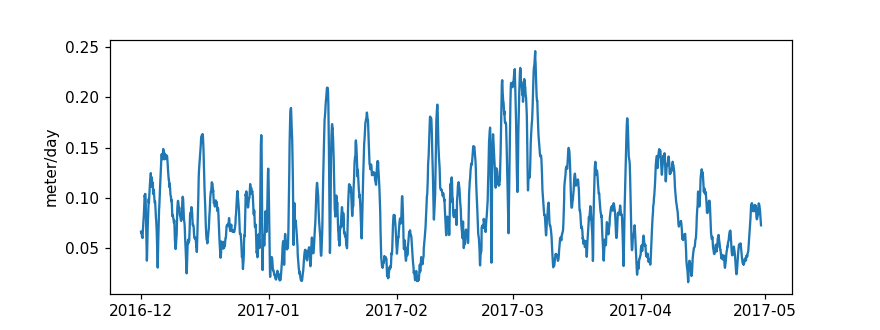

ValueError: x and y must have same first dimension, but have shapes (3601,) and (1465,)

In [543]:

fig, ax = plt.subplots(figsize=(8,3))
# plt.plot(ds.time, dHdt.to('m/day'))
plt.plot(ds.time, (Qnet / (cst['L_i'] * cst['rho_i'])).to('m/day'))
plt.plot(ds.time, (Qnet_with_Qe / (cst['L_i'] * cst['rho_i'])).to('m/day'))

<IPython.core.display.Javascript object>


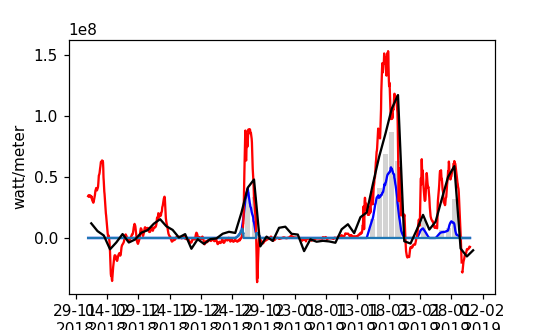

In [460]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(5,3))


# A = 30*100 *units('km')*units('km')

# A = 30 * 60 *units('km')*units('km')

# plt.plot(ds.time, (delivered_heat_content / (cst['L_i']*cst['rho_i']*A)).to('cm'))
# plt.plot(ds.time, Fi*units('hour'))



plt.plot(ds.time, Qnet*hourly_lengths, c='b')
plt.plot(ds.time, IHT, c='r')

# plt.plot(ds.time, Qnet*hourly_extents)
# plt.plot(ds.time, IHT*30*units('km').to('m'))

# net_Q = np.copy(IHT)
# net_Q[net_Q<0]= 0 * net_Q.units
# net_Q = Qnet*hourly_lengths - net_Q

IHT_noneg = np.copy(IHT)
IHT_noneg[IHT_noneg<0] = 0 * IHT_noneg.units

net_Q = np.copy(Qnet*hourly_lengths-IHT_noneg)
net_Q[net_Q<0] = 0 * net_Q.units
plt.plot(ds.time, net_Q)

# ax.set_xlim(datetime(2019,1,13), datetime(2019,1,22))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
date_fmt = mdates.DateFormatter('%d-%m\n%Y')
ax.xaxis.set_major_formatter(date_fmt)


ax.bar(pd.to_datetime(DS.time)+timedelta(hours=12), DS.bulk_length.values*1000000, color='lightgray')
plt.plot(pd.to_datetime(DS.time)+timedelta(hours=12), cum_ese10*1000000, c='k')

# plt.plot(ds.time, U.mean('z').values*units('m/s').to('km/day').magnitude*1000000, c='k')
# plt.scatter(pd.to_datetime(DS.time)+timedelta(hours=12), cum_ese10*1000000)
# plt.scatter(pd.to_datetime(DS.time)+timedelta(hours=12), (cum_ese10.magnitude*1000000), )

# plt.scatter(ds.time[:24*14], total_dist*1000000, c='r')


<IPython.core.display.Javascript object>


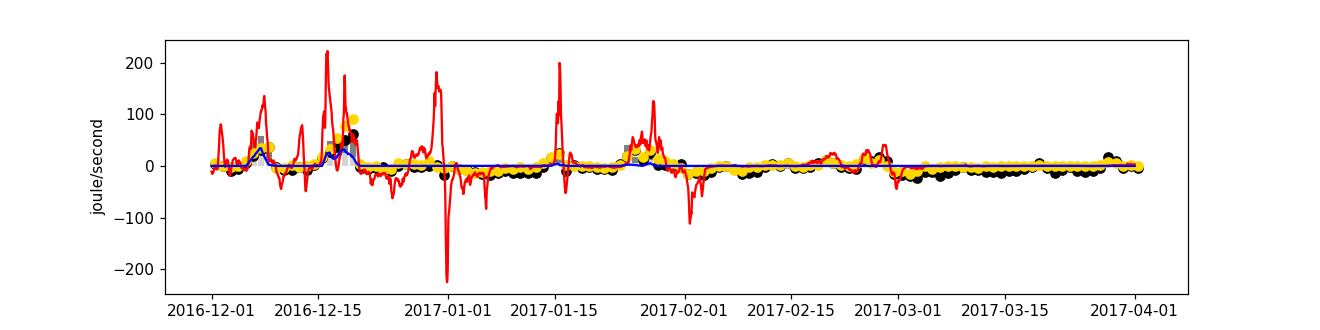

In [303]:
fig, ax = plt.subplots(figsize=(12,3))
# plt.plot(Qnet)

# plt.plot(IHT / (100 * units('km').to('m')))
# plt.plot(Qnet)

plt.plot(ds.time, 1e-10 * (20*units('km').to('m')) * IHT, c='r')
plt.plot(ds.time, 1e-10 * hourly_extents * Qnet, c='b')

# plt.plot(ds.time, 1e-2 * IHT / (hourly_lengths+5*units('km')), c='r')
# plt.plot(ds.time, 1e-2 * Qnet, c='b')

ax.bar(pd.to_datetime(DS.time)+timedelta(hours=12), DS.l_max.values, color='gray')
ax.bar(pd.to_datetime(DS.time)+timedelta(hours=12), DS.bulk_length.values, color='lightgray')
plt.scatter(pd.to_datetime(DS.time)+timedelta(hours=12), cum_ese10, c='k')
plt.scatter(pd.to_datetime(DS.time)+timedelta(hours=12), cum_esei, c='gold')


<IPython.core.display.Javascript object>


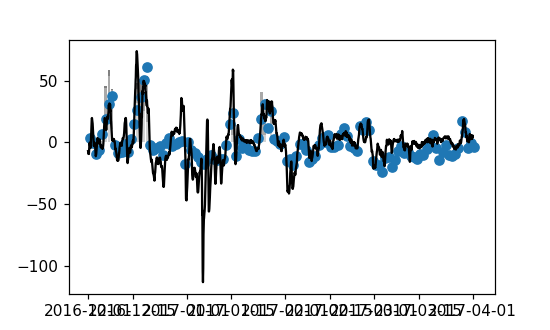

In [288]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(5,3))


ax.bar(pd.to_datetime(DS.time)+timedelta(hours=12), DS.l_max.values, color='gray')
ax.bar(pd.to_datetime(DS.time)+timedelta(hours=12), DS.l_per95.values, color='darkgray')
ax.bar(pd.to_datetime(DS.time)+timedelta(hours=12), DS.bulk_length.values, color='lightgray')


plt.plot(ds.time, U.mean('z').values*units('m/s').to('km/day').magnitude, c='k')
plt.scatter(pd.to_datetime(DS.time)+timedelta(hours=12), cum_ese10)
# plt.scatter(pd.to_datetime(DS.time)+timedelta(hours=12), (cum_ese10.magnitude*1000000), )

# plt.scatter(ds.time[:24*14], total_dist, c='r', s=5)

In [72]:
net_Q_perL = net_Q/hourly_lengths
net_fi = (net_Q_perL / (cst['L_i'] * cst['rho_i'])).to('cm/hour')


Vi = -0.025 * dw.u10.values * units('m/s').to('km/hour') 
# Vi = -0.03 * ua_HI.to('km/hour')
t = np.arange(len(Uair)) * units('hour')

collection_depth = 0.05 * units('m')

Fi = dHdt

X_mlip  = xp_over_time_iter(Vi, t, net_fi, Hi = collection_depth)
# X_lip  = xp_over_time_iter(Vi, t, qnet_convert, Hi = 0.1 * units('m'))
X_ip  = xp_over_time_iter(Vi, t, Fi, Hi = collection_depth)
X_zip  = xp_over_time_iter(Vi, t, np.zeros(len(Fi)) * units('cm/hour'), Hi = collection_depth)


<IPython.core.display.Javascript object>


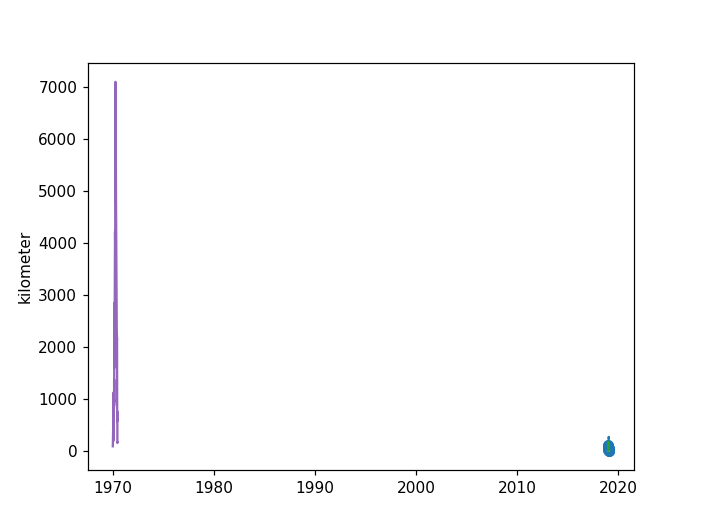

In [73]:
fig, ax = plt.subplots()
plt.plot(ds.time, X_zip)
plt.plot(ds.time, X_ip)
plt.plot(ds.time, X_mlip)

plt.bar(pd.to_datetime(DS.time) + timedelta(hours=12),
        (DS.l_max-DS.l_min).values, color='lightgray')
plt.scatter(pd.to_datetime(DS.time)+timedelta(hours=12), cum_ese10)

(-40.0, 10.0)

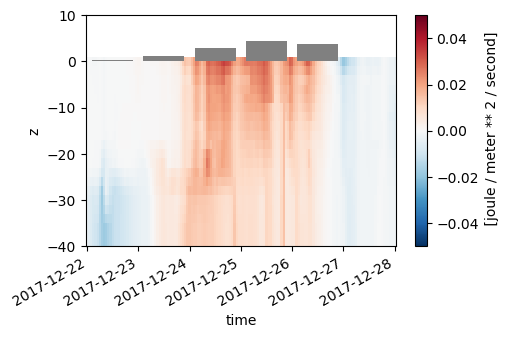

In [33]:
fig, ax = plt.subplots(figsize=(5,3))
# hc_perm3.plot()
(ht_perm3/100000000).plot(vmin=-0.05,vmax=0.05, cmap='RdBu_r')
# ax.set_xlim(datetime(2019,1,12), datetime(2019,1,22))

ax.bar(pd.to_datetime(DS.time)+timedelta(hours=12), DS.extent/1000, color='gray')

plt.ylim(-40,10)



In [35]:
# dt_sfc = (dso.T-dso.Tf).sel(depth=-16) * units('delta_degC')
# sig_sfc = dso.sig0.sel(depth=-16) * units('kg/m3')
# sfc_ht = (cst['Cp_o']*sig_sfc*sfc_ese_current.to('m/s')*dt_sfc* 40*units('m'))

# dt_sfc = (dso.T-dso.Tf).sel(depth=-16) * units('delta_degC')
# sig_sfc = dso.sig0.sel(depth=-16) * units('kg/m3')
# sfc_ht = (cst['Cp_o']*sig_sfc*sfc_ese_current.to('m/s')*dt_sfc* 40*units('m'))


# dt_sfc = (dso.T-dso.Tf).sel(depth=-16) * units('delta_degC')
# sig_sfc = (1000+dso.sig0.sel(depth=-16)) * units('kg/m3')
# sfc_ht = (cst['Cp_o']*sig_sfc*sfc_ese_current.to('m/s')*dt_sfc* 40*units('m'))

In [87]:
Z = -10
dt_sfc = ds.sel(z=Z).dT.values * units('delta_degC')
sig_sfc = ds.sig0.sel(z=Z).values * units('kg/m3')
sfc_flow = vectors.comp_along_theta(ds.u.sel(z=Z), ds.v.sel(z=Z), 145*units('degree')).values * units('m/s')
sfc_dz = np.abs(Z) * units('m')
sfc_ht2 = cst['Cp_o']*dt_sfc*sig_sfc*sfc_flow*sfc_dz

delivered_heat_content = (sfc_ht2 ) * units('hour').to('s')
# * (40*units('km').to('m'))

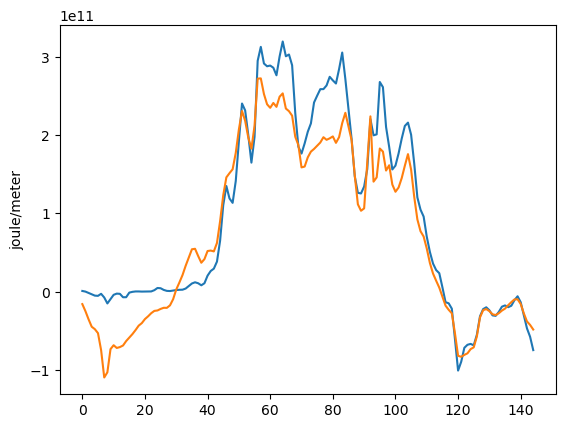

In [88]:
plt.plot(delivered_heat_content*4)
plt.plot(IHT * units('hour').to('s'))

<BarContainer object of 7 artists>

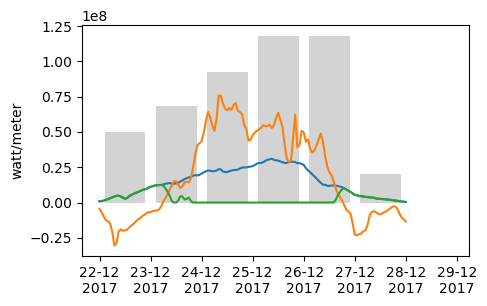

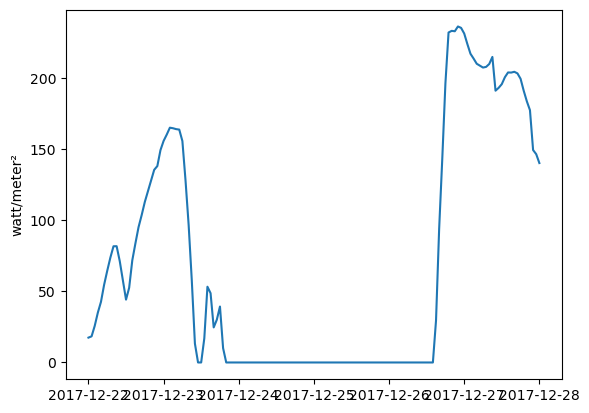

In [114]:
plt.plot(ds.time, net_Q/hourly_lengths)

In [ ]:
net_fi

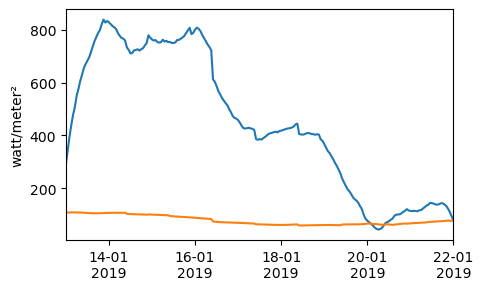

In [591]:

Twater = np.full(len(Ta), -1.8) * units('degC')

# Twater = dso.T.sel(depth=-16).values* units('degC')


# Tair = Ta
Uair = Ua_HI

# Tair = Ta
Uair = Ua

# define positive upward
Qlu = find_Qlu(Twater, cst['sigma_sb'], 0.98)
Qld = -find_Qld(Tair, cst['sigma_sb'], 0.95)
Qs = -find_Qs(Tair, Twater, cst['rho_a'], cst['Cp_a'], Uair)
# print(Qs)

Qnet = Qlu + Qld + Qs
Fi = (Qnet / (cst['L_i'] * cst['rho_i'])).to('cm/hour')

fig, ax = plt.subplots(figsize=(5,3))

ax.set_xlim(datetime(2019,1,13), datetime(2019,1,22))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
date_fmt = mdates.DateFormatter('%d-%m\n%Y')
ax.xaxis.set_major_formatter(date_fmt)

plt.plot(dso.time, Qs)
plt.plot(dso.time, Qlu+Qld)


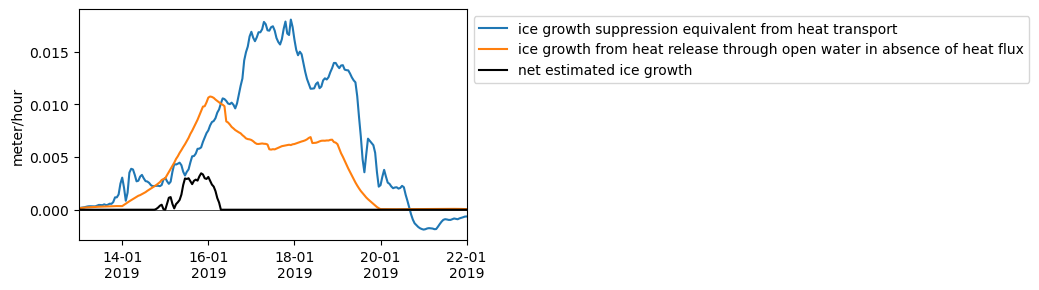

In [598]:
fig, ax = plt.subplots(figsize=(5,3))

ax.set_xlim(datetime(2019,1,13), datetime(2019,1,22))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
date_fmt = mdates.DateFormatter('%d-%m\n%Y')
ax.xaxis.set_major_formatter(date_fmt)



convert = -(cst['rho_i'] * cst['L_i'])
shelf_length = 100 * units('km').to('m')

iht_1d = IHT[time_cond].to('W/meter')
qnet_1d = -Qnet * hourly_lengths

iht_convert = (iht_1d/convert).to('m2/hour')  / shelf_length
qnet_convert = (qnet_1d/convert).to('m2/hour')  / shelf_length

plt.plot(dso.time, -iht_convert, label='ice growth suppression equivalent from heat transport')
plt.plot(dso.time, qnet_convert, label='ice growth from heat release through open water in absence of heat flux')
# plt.plot(dso.time, iht_convert + qnet_convert, c='gray')


net_fi = iht_convert + qnet_convert
net_fi[net_fi < 0*units('m/hour')] = 0*units('m/hour')
net_fi[iht_convert > 0*units('m/hour')] = 0*units('m/hour')

plt.plot(dso.time, net_fi, c='k', label='net estimated ice growth')


# plt.plot(dso.time,(Qnet/convert).to('cm/hour'))
plt.legend(bbox_to_anchor=(1,1))
plt.axhline(0, lw=0.5, c='k', zorder=-1)

In [597]:
iht_1d.units

<Unit('watt / meter')>

In [588]:
Vi = -0.025 * dw.u10.values * units('m/s').to('km/hour') 
# Vi = -0.03 * ua_HI.to('km/hour')
t = np.arange(len(Uair)) * units('hour')

collection_depth = 0.1 * units('m')

X_mlip  = xp_over_time_iter(Vi, t, net_fi, Hi = collection_depth)
X_lip  = xp_over_time_iter(Vi, t, qnet_convert, Hi = collection_depth)
X_ip  = xp_over_time_iter(Vi, t, Fi, Hi = collection_depth)
X_zip  = xp_over_time_iter(Vi, t, np.zeros(len(Fi)) * units('cm/hour'), Hi = collection_depth)


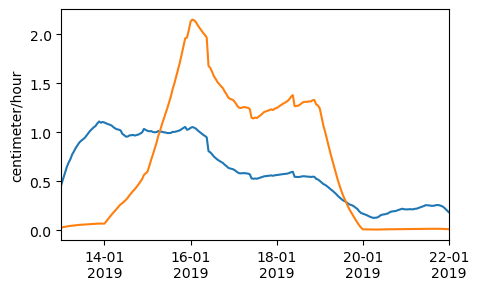

In [589]:
fig, ax = plt.subplots(figsize=(5,3))

ax.set_xlim(datetime(2019,1,13), datetime(2019,1,22))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
date_fmt = mdates.DateFormatter('%d-%m\n%Y')
ax.xaxis.set_major_formatter(date_fmt)

plt.plot(dso.time, Fi)
plt.plot(dso.time, qnet_convert)

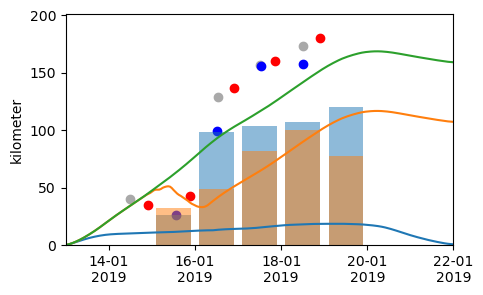

In [590]:
fig, ax = plt.subplots(figsize=(5,3))

ax.set_xlim(datetime(2019,1,13), datetime(2019,1,22))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
date_fmt = mdates.DateFormatter('%d-%m\n%Y')
ax.xaxis.set_major_formatter(date_fmt)

plt.plot(dso.time, X_ip)
# plt.plot(dso.time, X_lip)
plt.plot(dso.time, X_mlip)
plt.plot(dso.time, X_zip)

# plt.bar(DS.time, DS.max_length.values, alpha=0.5)

plt.bar(pd.to_datetime(DS.time)+timedelta(hours=12), DS.l_max.values, alpha=0.5)
plt.bar(pd.to_datetime(DS.time)+timedelta(hours=12), (DS.extent/(DS.w_per95-DS.w_per5)).values, alpha=0.5)

offset = 15
ax.scatter(viirs_times, offset+viirs_lengths, color='darkgray', zorder=-1)
ax.scatter(aqua_des_times, offset+aqua_des_lengths, color='b', zorder=-1)
ax.scatter(terra_asc_times, offset+terra_asc_lengths, color='r', zorder=-1)

# ax.scatter(pd.to_datetime(df_time)+timedelta(hours=12), 
#            np.cumsum(df_esei), c='green')

# ax.scatter(pd.to_datetime(df_time)+timedelta(hours=12), 
#            np.cumsum(df_ese10), c='k')


In [531]:
viirs_lengths

array([ 25, 114, 142, 158])

In [355]:
convert

<Quantity(3.06278e+08, 'joule / meter ** 3')>

In [336]:
iht_1d = -((IHT.to('J/meter/hour')) / (cst['L_i']*cst['rho_i']))
iht_1d    

<Quantity([-403.40323857 -409.36462038 -413.35104005 ...   -8.34865054   -8.64421449
   -8.27226847], 'meter ** 2 / hour')>

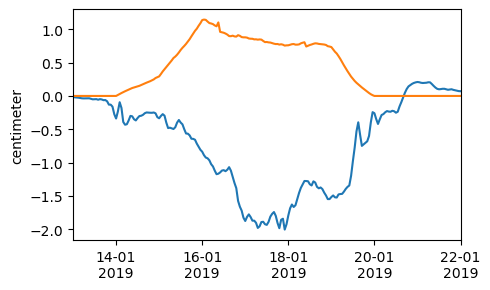

In [344]:
fig, ax = plt.subplots(figsize=(5,3))

ax.set_xlim(datetime(2019,1,13), datetime(2019,1,22))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
date_fmt = mdates.DateFormatter('%d-%m\n%Y')
ax.xaxis.set_major_formatter(date_fmt)

plt.plot(ds.time, heat_delivered, label='Ice growth suppression')
plt.plot(dso.time, heat_removed, label='Ice growth for T=Tf')


In [342]:
cst['Cp_o']

<Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>

In [ ]:
np.where(ds.time.values)

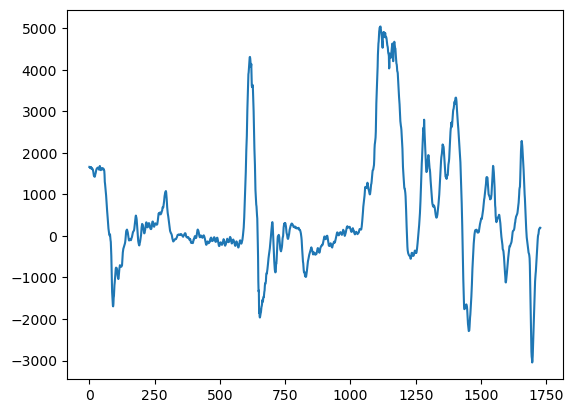

In [307]:
plt.plot(flow_dist)

In [306]:
flow_dist

array([1664.31818741, 1663.06326779, 1642.40619636, ...,  193.38632695,
        203.01907036,  196.80635365])

In [305]:
flow_dist = U.mean('z').values * (units('m/s') * units('hour').to('s')).magnitude

In [ ]:
a_dt64.interp(time=pd.date_range("1/1/2000", "1/3/2000", periods=3))

In [230]:
hourly_extents = np.array([])
for time in pd.to_datetime(dso.time.values):
    time_no_hour = time - timedelta(hours=time.hour)
    hourly_extents = np.append(hourly_extents, DS.extent.sel(time = time_no_hour).values)
hourly_extents = hourly_extents * units('km2')

In [225]:
time_no_hour

Timestamp('2019-01-25 00:00:00')

In [227]:
DS.extent.sel(time = time_no_hour).values

array(0.)

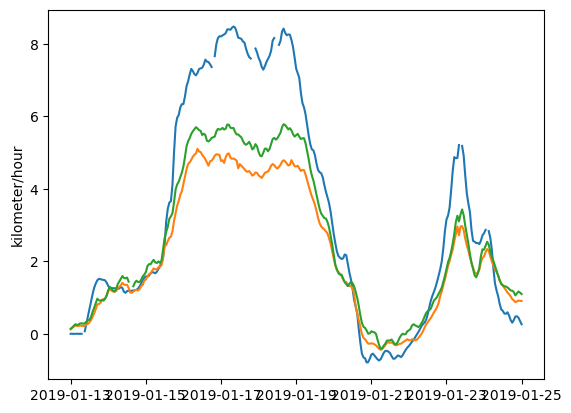

In [8]:
%matplotlib inline
ese_icedrift = vectors.comp_along_theta(dsi.u, dsi.v, 145*units('degree')).values * units('m/s').to('km/hour')
ese_current = vectors.comp_along_theta(dsc_dma.u, dsc_dma.v, 145*units('degree')).values * units('m/s').to('km/hour')
sfc_ese_current = vectors.comp_along_theta(dsc.u.sel(depth=-10), 
                                           dsc.v.sel(depth=-10), 145*units('degree')).values * units('m/s').to('km/hour')


current_angle = vectors.vector_angle(dsc_dma.u.values, dsc_dma.v.values).magnitude
current_angle[current_angle<0]+=360

ice_angle = vectors.vector_angle(dsi.u.values, dsi.v.values).magnitude
ice_angle[ice_angle<0]+=360


# plt.plot(ESE.mean('depth')*24)
plt.plot(dsi.time, ese_icedrift)
plt.plot(dsi.time, ese_current)
plt.plot(dsi.time, sfc_ese_current)

# plt.xlim(0,200)

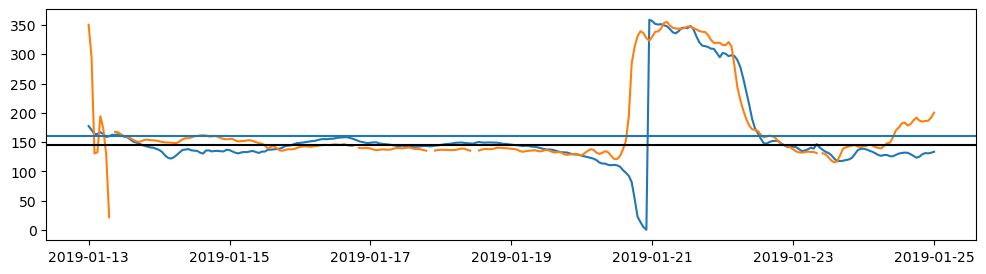

In [46]:
fig, ax = plt.subplots(figsize=(12,3))
plt.plot(dsc.time, current_angle)
plt.plot(dsc.time, ice_angle)
plt.axhline(145,c='k')

plt.axhline(160)

In [9]:
df = pd.read_csv('/Volumes/Seagate_Jewell/KenzieStuff/met_data/HIYT/herschel-island-yt_fed4_1534_1033.csv')
df = pd.DataFrame(df).set_index('time')
ti = time_range.start.strftime('%Y-%m-%dT%H:%M:%SZ')
tf = time_range.stop.strftime('%Y-%m-%dT%H:%M:%SZ')
date_time_range_df = df.loc[ti:tf]
Ta = date_time_range_df.air_temperature.values.astype(float) * units('degC')
Ua = date_time_range_df.wind_speed.values.astype(float) * units('m/s')



# df_times = pd.to_datetime(date_time_range_df.index)

df_times = np.array([datetime.strptime(datestr, '%Y-%m-%dT%H:%M:%SZ') for datestr in date_time_range_df.index])


Ta_HI, _ = tseries.linear_interpolate(pd.to_datetime(dsc.time.values), df_times, 
                                Ta, max_dt=6*units('hour'))

Ua_HI, _ = tseries.linear_interpolate(pd.to_datetime(dsc.time.values), df_times, 
                                Ua, max_dt=6*units('hour'))


wind_dir = 10*date_time_range_df.wind_from_direction.values.astype(float) 
ua_HI = Ua * np.cos(wind_dir*np.pi/180)
va_HI = Ua * np.sin(wind_dir*np.pi/180)

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_86866/833634480.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Volumes/Seagate_Jewell/KenzieStuff/met_data/HIYT/herschel-island-yt_fed4_1534_1033.csv')


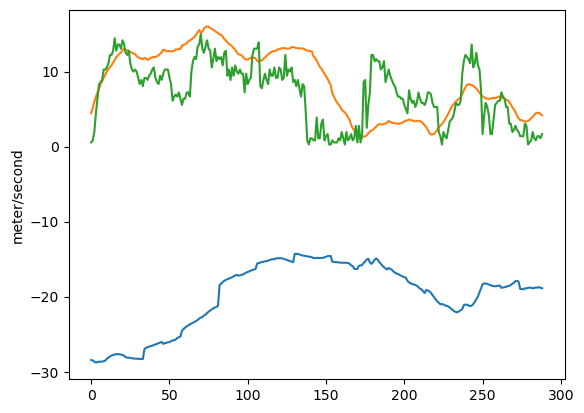

In [512]:
fig, ax = plt.subplots()
plt.plot(Ta.magnitude)
plt.plot(Ua.magnitude)
plt.plot(Ua_HI)

In [12]:

# dT = (Tw_dma[0] - Tf_dma[0]).magnitude * units('delta_degC')
# DQ = dT * (cst['Cp_o']*sigi) * 40 * units('m')


# dTi = - (dQi / (cst['Cp_o'] * sig0_dma[0] * dZ))

# def find_change_ihc(dTi, sig0, dZ, cst):
    
#     # change in heat content
#     d_ihc_dma = cst['Cp_o'] * dTi * sig0 * dZ

#     return d_ihc_dma



In [74]:
def find_dQ(Tw, Ta, Ua, cst):
    
    # define positive upward
    Qlu = find_Qlu(Tw, cst['sigma_sb'], 0.98)
    Qld = -find_Qld(Ta, cst['sigma_sb'], 0.95)
    Qs = -find_Qs(Ta, Tw, cst['rho_a'], cst['Cp_a'], Ua)
    # print(Qs)

    Qnet = Qlu + Qld + Qs
    
    return Qnet, Qlu, Qld, Qs

def DT_from_hc(hc, sig0, dZ, cst):
    
    # temperature relative to freezing from heat content
    DT = hc / (cst['Cp_o'] * sig0 * dZ)

    return DT

In [75]:


def find_cooling_time(ihc_dma, Tw_dma, sig0_dma, Tf_dma, 
                      Ta, Ua, cst, dZ,sec_per_hour, TT = 0, duration = 24*7):

    # initial temperature and heat content at this time
    all_hc =  np.array([ihc_dma[TT].magnitude]) * ihc_dma.units
    all_Tw = np.array([Tw_dma[TT].magnitude]) * Tw_dma.units
    isig0 = sig0_dma[TT]
    iTf = Tf_dma[TT]

    all_Qn = np.array([])

    for tt in range(TT, TT+duration):

        # heat balance from air temp and atmos. conditions
        Qnet, Qlu, Qld, Qs = find_dQ(all_Tw[-1], Ta[tt], Ua[tt], cst)
        hourly_dQ = (Qnet * sec_per_hour).to('J/m2')

        all_Qn = np.append(all_Qn, hourly_dQ)

        # new heat content
        nhc = all_hc[-1] - all_Qn[-1]

        # new temperature relative to freezing
        nDT = DT_from_hc(nhc, isig0, dZ, cst)

        # new temp
        nTw = nDT + iTf

        if nTw > iTf:
            all_hc = np.append(all_hc, nhc)
            all_Tw = np.append(all_Tw, nTw)

        else:
            break
            
            
    return len(all_Tw)


In [85]:

# Twater = np.full(len(Tw_dma), -1.75)*units('degC')
# Tfreeze = np.full(len(Tw_dma), -1.8)*units('degC')



Twater = Tw_dma #+ 0.25 * units('delta_degC')
Tfreeze = Tf_dma



dT_dma = (Twater.magnitude - Tfreeze.magnitude) * units('delta_degC')

sec_per_hour = units('hour').to('s')
dZ = 40 * units('m')
ihc_dma = cst['Cp_o'] * dT_dma * sig0_dma * dZ

ese_current = U.mean('z') * units('m/s').to('km/hour')


Qnet, Qlu, Qld, Qs = find_dQ(Twater, Ta, Ua, cst)
Qnet_hourly = Qnet * sec_per_hour

In [79]:
plt.plot(Qnet)
plt.plot(Qs)
plt.plot(Ua.magnitude*100)
plt.plot((Ta.magnitude+30)*100)

ConversionError: Failed to convert value(s) to axis units: <Quantity([428.55928145 482.83569751 538.37550677 585.27538921 626.13383249
 659.01321178 702.5338627  726.7299679  756.03766051 777.71353011
 805.1874094  818.96649778 829.30615525 837.69969535 850.7900193
 862.41363695 878.21498051 886.62138839 897.53712133 900.78565417
 913.93174196 921.82344082 908.54959495 915.57687508 906.46036055
 892.34046962 878.55663102 876.31363266 878.76843118 870.4551292
 860.57853518 852.10107856 848.89795039 842.71311258 839.08042707
 831.6420177  818.4050564  820.19824626 828.55521799 828.44995284
 830.05774979 823.54517778 829.88593313 833.51372586 845.69215609
 851.00500029 881.07157556 872.98135188 863.11244639 855.43382993
 852.35583827 843.12039714 842.59350969 838.85361465 844.55144726
 836.25978398 833.73515251 822.69897561 820.49404887 813.30132367
 812.70410638 814.3759922  818.68149066 820.66749261 821.37792894
 824.77917249 826.13564855 832.13881061 830.30830139 837.89068466
 807.8949201  804.51059818 811.8853674  810.11423527 803.26151812
 786.31133371 763.15754275 742.63659151 726.34071684 706.39055707
 692.38089889 676.11817737 609.83730377 596.86178125 581.81120511
 562.7568426  550.36704961 539.32610566 532.95039351 524.17132949
 515.98031863 508.86797011 498.01269126 486.05101628 484.17234834
 483.87939162 483.74451617 475.3019763  468.28176554 465.40773258
 469.14882725 475.39654666 483.20147361 490.80059344 493.48311683
 492.33002166 471.97655947 468.92528198 472.73779694 471.9122054
 476.21533637 479.63596112 484.18676767 492.20123348 495.68158869
 497.29703248 497.59492309 495.24802045 491.69242308 489.48764792
 483.24505807 478.93203623 477.35185272 475.98383024 475.03881195
 470.09908729 470.11659023 472.7114274  483.17670523 484.92214756
 460.15258364 461.73996071 461.11225072 461.37966186 461.32071982
 462.86192689 461.82956021 458.39989822 463.01712145 464.53168656
 470.7873213  476.85079325 457.37581883 458.99044953 449.65415669
 444.66585731 436.23111699 431.74930418 422.4745381  413.91849093
 403.67700286 394.75948736 380.57658784 366.89498686 329.00912428
 315.09322505 301.12350766 289.38167947 282.11485661 271.07498316
 261.72525936 255.57524224 251.50009506 243.91885321 228.89138295
 215.88522971 185.69696375 168.91295774 159.88808016 156.19885256
 152.29645449 147.73856866 139.43862934 133.37870532 130.83001189
 134.72510827 140.61480783 153.77827475 165.19514347 171.97833164
 179.30919499 191.75945887 202.77830945 216.68607285 223.61018303
 225.74566847 226.96425669 231.89467604 239.06457704 245.93217242
 257.63598757 252.29711688 249.93752807 249.13380645 251.27194806
 250.11775613 249.53126778 255.04254428 256.95100253 264.75052323
 272.74822467 279.12531449 279.38765444 287.13955846 284.9635805
 282.98425959 278.07123902 276.87055403 279.01442933 283.38785865
 282.21317355 277.41928996 269.17024359 255.2444519  239.96259654
 219.86952711 198.62196178 187.82904989 188.74350943 193.07239425
 209.20738485 224.80733239 247.06178744 257.51004493 271.7453197
 285.44850713 303.09563566 322.68728888 342.95968998 368.84828512
 392.82868468 410.43930357 423.66801657 435.75511128 446.06946876
 453.96084577 465.34759555 480.68586713 504.70316504 524.84670569
 541.95421583 549.27121779 544.27622116 540.79765744 531.85480636
 516.75393826 504.79520306 487.74154257 468.94546003 446.75465696
 438.90786269 430.80392458 422.60262293 418.00942141 416.94921909
 418.61433777 420.12627159 420.04202465 416.40366011 418.65837322
 423.35010715 419.82795876 412.47953511 413.90283224 410.50531147
 402.50854526 396.07602953 383.16295509 363.94248831 344.9458726
 331.33495487 314.94911345 292.17575254 276.96963587 266.77620424
 268.85600716 262.14791952 259.50759941 259.14875726 263.50770003
 270.58852718 283.79471023 294.04744453 307.36130288 320.54198656
 321.85065638 320.38536695 308.45856024 302.13291514 306.29322498
 327.56687895 356.02439628 375.03279259 386.96914105 398.01593273
 411.74803379 427.07345102 443.86823203 460.95614857 497.48154711
 528.36296194 553.30984997 581.3786595  601.50121381 611.08801105
 618.48344188 630.56598337 641.54478442 663.97631015 678.10454393
 683.31402005 692.00777055 698.1500867  702.26968313 694.59913073
 693.84207263 692.44617987 678.70476848 666.35297068 649.11559803
 642.14591344 627.17035698 610.83319775 599.10197298 583.35106869
 570.6128261  561.67857677 556.28793805 556.54808496 558.37297867
 557.60400651 547.72182871 538.81401697 529.93045473 540.29786962
 540.48798563 539.53126686 537.73889103 541.7924523  548.79194297
 552.0339269  555.56104983 558.26539334 550.80484358 548.79315762
 562.22394793 562.54955391 562.57689945 569.81332524 570.88936479
 575.06929231 592.37942305 602.98429285 605.205888   597.64267315
 585.45759778 569.93041559 551.95324274 545.22631215 530.39792201
 507.70558831 484.86095175 453.33260252 422.69141597 396.43989816
 376.77971572 364.01583102 353.23062784 338.43340174 324.87853018
 302.71673388 284.1988632  264.43683317 237.33653924 208.81200837
 183.63248947 161.05476953 143.7380052  127.01181012 111.08590229
 102.84064125  98.78006134 107.92502221 113.83487977 115.85824446
 118.11321868 116.89856606 116.6686953  117.51079948 120.48525172
 131.88168212 144.11757323 162.70345033 181.42538101 195.97208881
 218.50843101 235.80993425 247.27611561 259.79824798 275.5289988
 296.13886919 309.44692359 317.20601191 319.12394422 327.51001751
 336.66142818 350.61877973 366.95184661 379.92573362], 'watt / meter ** 2')>

In [107]:


# initial time to start integrating
# #===============
# TT = 4
# #===============


# dT_dma = (Tw_dma.magnitude - Tf_dma.magnitude) * units('delta_degC')


total_T = np.array([])
total_dist = np.array([])


for TT in range(24*14):
    
#     T = find_cooling_time(ihc_dma, Tw_dma, 
#                           sig0_dma, Tf_dma, Ta , Ua, cst, dZ, TT = TT)
#     ihc_dma
    T = find_cooling_time(IHC, Twater, 
                          sig0_dma, Tfreeze, Ta, Ua, cst, dZ, sec_per_hour, TT = TT, duration = 24*6)

    total_T = np.append(total_T, T)
    
    dist = np.sum(ese_current[TT:TT+T])
    total_dist = np.append(total_dist, dist)


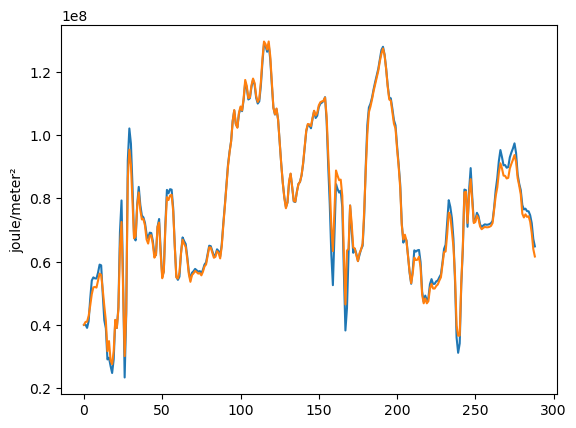

In [37]:
plt.plot(IHC_event)
plt.plot(ihc_dma)

<IPython.core.display.Javascript object>


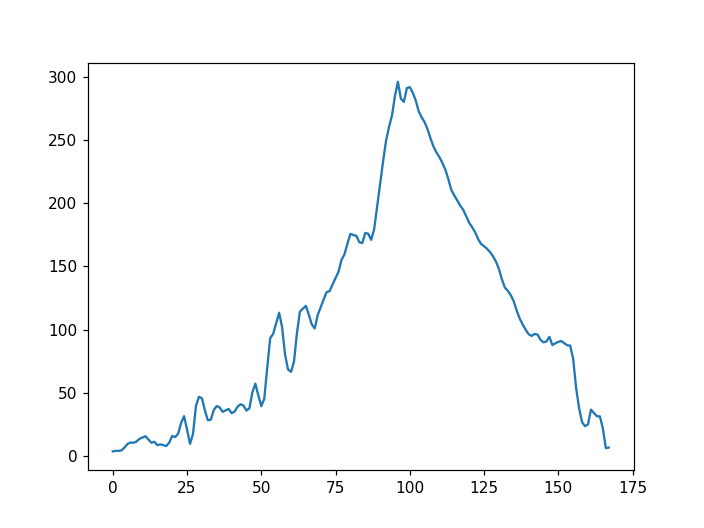

In [87]:
# cooling_time = (ihc_dma/Qnet).to('hour')
# plt.plot(dso.time, current*cooling_time)

# plt.plot(dso.time, current*cooling_time)

fig, ax = plt.subplots()
plt.plot(total_dist)
# plt.plot(dso.time[:24*5], current[:24*5].magnitude*total_T)
# plt.bar(DS.time, DS.length.values*units('km'))
# plt.ylim(-100,1500)

In [ ]:
drho = dso.sig0.sel(depth=-36) - dso.sig0.sel(depth=-16)

In [ ]:
plt.plot(drho.time, drho)

ValueError: x and y must have same first dimension, but have shapes (289,) and (217,)

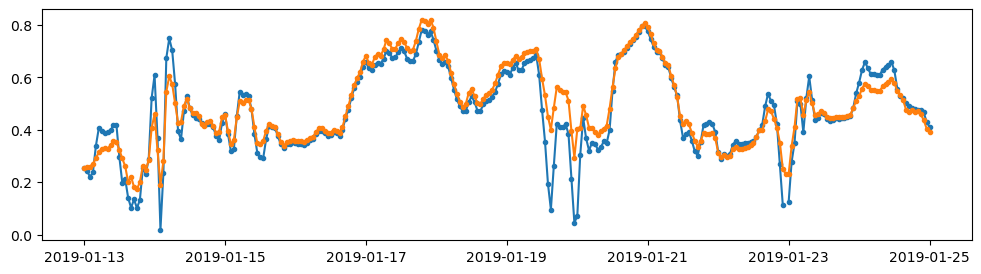

In [684]:
fig, ax= plt.subplots(figsize=(12,3))
plt.plot(dso.time, (dso.T-dso.Tf).sel(depth=-16), marker='.')
plt.plot(dso.time, (dso.T-dso.Tf).mean('depth'), marker='.')
plt.plot(dso.time, drho.values)

In [490]:

# Tw = dso.T.sel(depth=-16).values * units('degC')

# Twater = dso.T.mean('depth').values * units('degC')

Twater = np.full(len(Ta), -1.8) * units('degC')
# Tair = Ta_HI
# Uair = Ua_HI


Tair = Ta
Uair = Ua

# define positive upward
Qlu = find_Qlu(Twater, cst['sigma_sb'], 0.98)
Qld = -find_Qld(Tair, cst['sigma_sb'], 0.95)
Qs = -find_Qs(Tair, Twater, cst['rho_a'], cst['Cp_a'], Uair)
# print(Qs)

Qnet = Qlu + Qld + Qs
dHdt = (Qnet / (cst['L_i'] * cst['rho_i'])).to('cm/hour')

Fi = dHdt
# Vi = ua_ice_drift

# Vi = -0.025 * ua_HI.to('km/hour')
Vi = -0.025 * dw.u10.values * units('m/s').to('km/hour')
t = np.arange(len(Uair)) * units('hour')

X_ip_v0  = xp_over_time_iter(Vi, t, Fi, Hi = 0.05 * units('m'))
X_ip  = xp_over_time_iter(Vi, t, Fi, Hi = 0.1 * units('m'))
X_ip_v2  = xp_over_time_iter(Vi, t, Fi, Hi = 0.2 * units('m'))
# X_hip = xp_over_time_iter(Vi, t, 0.1*Fi, Hi = 0.1 * units('m'))
X_zip = xp_over_time_iter(Vi, t, np.full(len(Fi), 0)*units('m/hour'), Hi = 0.1 * units('m'))


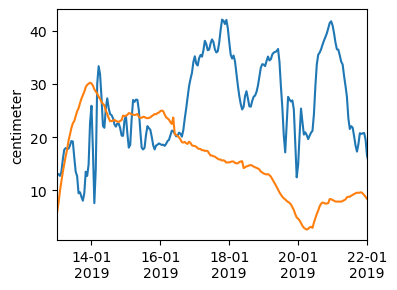

In [491]:
fig, ax = plt.subplots(figsize=(4,3))
# plt.plot(dsi.time, (IHC_event/Qnet.to('J/(m2*hour)')))

# plt.plot(dsi.time, (IHC_event))


plt.plot(dsi.time, (IHC_event/(cst['rho_i']*cst['L_i'])).to('cm'))
plt.plot(dsi.time, Fi.to('cm/day').magnitude)

ax.set_xlim(datetime(2019,1,13), datetime(2019,1,22))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
date_fmt = mdates.DateFormatter('%d-%m\n%Y')
ax.xaxis.set_major_formatter(date_fmt)


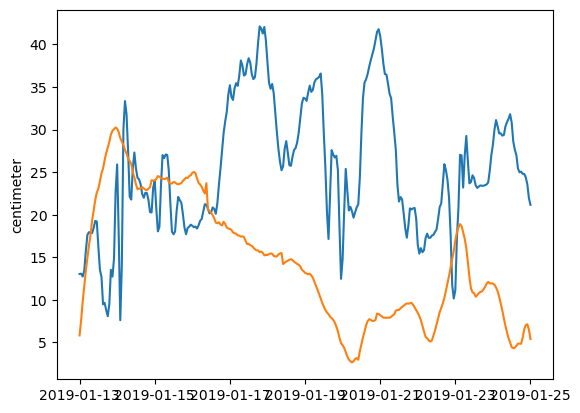

In [72]:
plt.plot(dsi.time, (IHC_event/(cst['rho_i']*cst['L_i'])).to('cm'))
plt.plot(dsi.time, Fi.to('cm/day').magnitude)

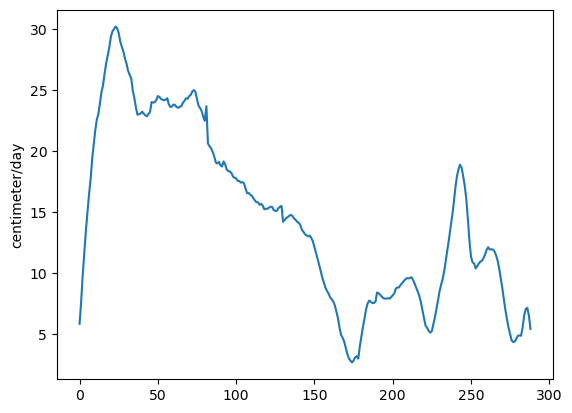

In [69]:
plt.plot(Fi.to('cm/day'))

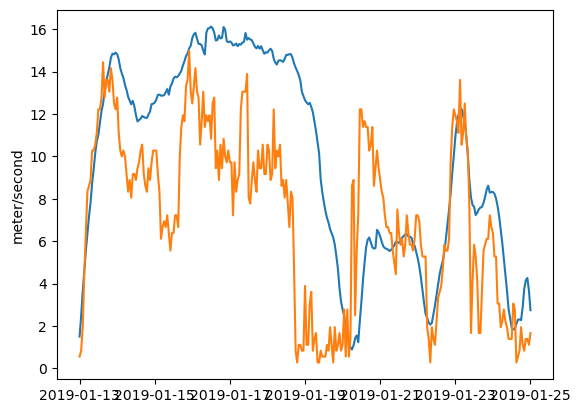

In [19]:
plt.plot(dsi.time, Ua)
plt.plot(dsi.time, Ua_HI)

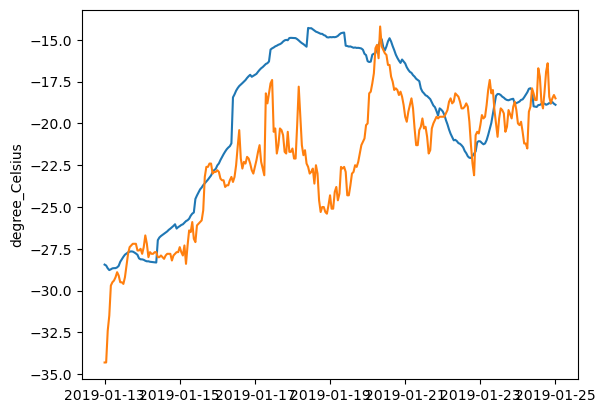

In [31]:
# plt.plot(Vi)
# plt.plot(ua_ice_drift)

plt.plot(dsi.time, Ta)
plt.plot(dsi.time, Ta_HI)

(-10.0, 250.0)

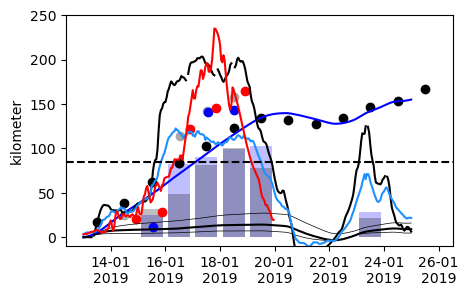

In [34]:
fig, ax = plt.subplots(figsize=(5,3))

ax.bar(pd.to_datetime(DS.time)+timedelta(hours=12), 
       (DS.l_per95), color='blue', zorder=-1, alpha=0.25)

ax.bar(pd.to_datetime(DS.time)+timedelta(hours=12), 
       DS.extent/(DS.w_per95-DS.w_per5), color='k', zorder=-1, alpha=0.25)

ax.plot(dso.time, X_ip, c='k')
ax.plot(dso.time, X_ip_v0, lw=0.5, c='k')
ax.plot(dso.time, X_ip_v2, lw=0.5, c='k')
# plt.plot(X_hip)
ax.plot(dso.time, X_zip, c='b')


ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
date_fmt = mdates.DateFormatter('%d-%m\n%Y')
ax.xaxis.set_major_formatter(date_fmt)

offset = 0
ax.scatter(viirs_times, offset+viirs_lengths, color='darkgray', zorder=-1)
ax.scatter(aqua_des_times, offset+aqua_des_lengths, color='b', zorder=-1)
ax.scatter(terra_asc_times, offset+terra_asc_lengths, color='r', zorder=-1)

# ax.scatter(pd.to_datetime(df_time)+timedelta(hours=12), 
#            np.cumsum(df_esei), c='green')

ax.scatter(pd.to_datetime(df_time)+timedelta(hours=12), 
           np.cumsum(df_ese10), c='k')

# ax.scatter(dso.time, np.cumsum(ua_ice_drift.magnitude))

plt.plot(dsi.time, ese_icedrift.to('km/day').magnitude+offset, c='k')
plt.plot(dsi.time, ese_current.to('km/day').magnitude+offset, c='dodgerblue')

plt.plot(dsi.time[:24*7], total_dist.magnitude, c='r')

plt.axhline(85, ls='dashed', c='k')
plt.ylim(-10,250)

(-40.0, 15.0)

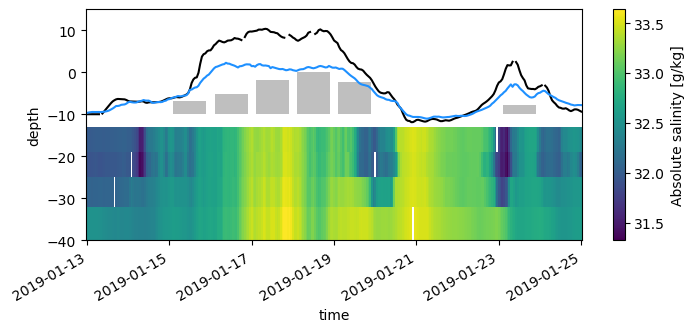

In [107]:
fig, ax = plt.subplots(figsize=(8,3))
# (dso.T-dso.Tf).plot()
(dso.Sa).plot()

ax.bar(pd.to_datetime(DS.time)+timedelta(hours=12), 
       (DS.extent/(DS.w_per95-DS.w_per5))/10, bottom = -10, 
       color='k', zorder=-1, alpha=0.25)
plt.plot(dsi.time, ese_icedrift.to('km/day').magnitude/10 -10, c='k')
plt.plot(dsi.time, ese_current.to('km/day').magnitude/10 -10, c='dodgerblue')


ax.set_ylim(-40,15)

# (dso.sig0).plot()

In [35]:
with xr.open_dataset(f'../data/polynya_size/daily_polynya_{2019}_sic10_v7.2_radius25km.nc') as DS:

    DS
#     DS = DS.sel(time = time_range)

#     DS['t'] = ((DS.time.values - DS.time.values[0]) / np.timedelta64(1, 's')) * units('s').to('hour')

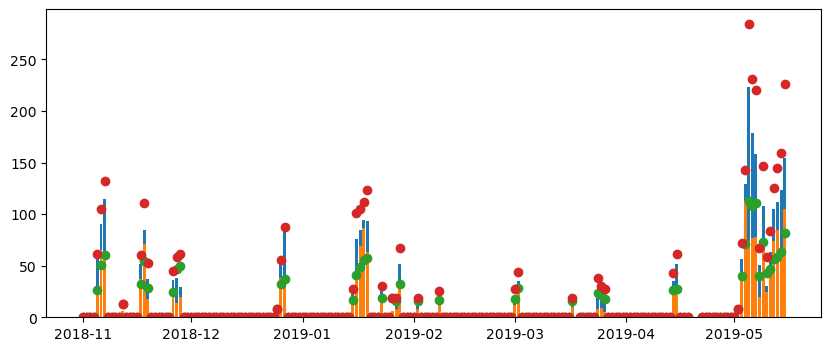

In [36]:
fig, ax = plt.subplots(figsize=(10,4))


widths = (DS.w_per95-DS.w_per5) + 6.25
widths[np.where(DS.w_per95==DS.w_per5)] = 6.25
widths[DS.extent==0]=0

lengths = (DS.l_per95-DS.l_per5)+6.25
lengths[DS.extent==0]=0

plt.bar(DS.time, lengths)
plt.bar(DS.time, DS.extent / widths)
plt.scatter(DS.time, DS.com_length)
plt.scatter(DS.time, DS.max_length)

In [15]:
DS

<xarray.Dataset>
Dimensions:               (time: 196)
Coordinates:
  * time                  (time) datetime64[ns] 2017-11-01 ... 2018-05-15
Data variables: (12/36)
    N                     (time) float64 ...
    extent                (time) float64 0.0 0.0 0.0 ... 1.95e+03 3.511e+03
    max_length            (time) float64 ...
    max_length_direction  (time) float64 ...
    com_length            (time) float64 ...
    com_direction         (time) float64 ...
    ...                    ...
    land_extent           (time) float64 ...
    ice_extent            (time) float64 ...
    ocean_extent          (time) float64 ...
    other_polynya_extent  (time) float64 ...
    polynya_extent        (time) float64 ...
    miss_flag             (time) bool ...

In [106]:
dso

<xarray.Dataset>
Dimensions:  (depth: 4, time: 289)
Coordinates:
  * depth    (depth) float64 -36.0 -28.0 -22.0 -16.0
  * time     (time) datetime64[ns] 2019-01-13 2019-01-13T01:00:00 ... 2019-01-25
Data variables:
    T        (depth, time) float64 -1.639 -1.618 -1.615 ... -1.311 -1.345 -1.361
    Sp       (depth, time) float64 32.35 32.35 32.35 32.35 ... 32.37 32.32 32.27
    Sa       (depth, time) float64 32.51 32.51 32.5 32.5 ... 32.52 32.48 32.43
    Ct       (depth, time) float64 -1.633 -1.612 -1.609 ... -1.304 -1.338 -1.354
    Tf       (depth, time) float64 -1.792 -1.792 -1.792 ... -1.778 -1.775 -1.772
    sig0     (depth, time) float64 26.03 26.03 26.03 26.02 ... 26.04 26.0 25.96
Attributes:
    lat:      69.7718
    lon:      -139.2582

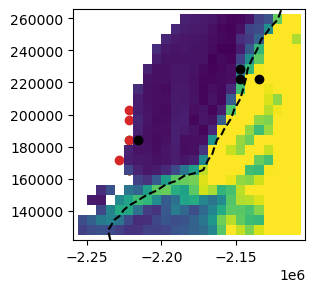

In [666]:
fig, ax = plt.subplots(figsize=(3,3))



for currtime in DS.time[2:-3]:
    curr_xx_str = str(DS.sel(time=currtime).poly_interior_xx.values)
    curr_yy_str = str(DS.sel(time=currtime).poly_interior_yy.values)
    
    poly_xx = np.array([float(curr_xx) for curr_xx in curr_xx_str.split('_')[1:]])
    poly_yy = np.array([float(curr_yy) for curr_yy in curr_yy_str.split('_')[1:]])
    
    ax.scatter(poly_xx, poly_yy)
    
    max_xx, max_yy = sic['proj'].transform_point(DS.sel(time=currtime).max_length_lon.values, 
                                  DS.sel(time=currtime).max_length_lat.values, ccrs.PlateCarree())
    ax.scatter(max_xx, max_yy, zorder=100, c='k')
    
    
with xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/GEBCO/re-gridded/master_625kmASI_V1.nc') as dsb:
    
    dsb_crop = dsb.sel(xx = slice(poly_xx.min()-(5*6250), poly_xx.max()+(5*6250)), 
            yy = slice(poly_yy.min()-(5*6250), poly_yy.max()+(5*6250)))
                        
# dsb_crop.avg.plot(zorder=-1, vmin=-150, vmax=00)
# ax.scatt/'er((avg_depth<-100).xx, (avg_depth<-100).yy, c='orange')

dsxx, dsyy = np.meshgrid(dsb_crop.xx, dsb_crop.yy)
# depth_range = (dsb_crop.avg < -70) & (dsb_crop.avg > -130)
# ax.scatter(dsxx[depth_range], dsyy[depth_range], c='orange', zorder=100)

ax.contour(dsxx, dsyy, dsb_crop.avg, levels=[-100], colors=['k'])

ddim0 = (dsb_crop.avg.values[2:, 1:-1] - dsb_crop.avg.values[:-2, 1:-1])
ddim1 = (dsb_crop.avg.values[1:-1, 2:] - dsb_crop.avg.values[1:-1, :-2])
grad = np.sqrt(ddim0**2+ddim1**2)
grad[dsb_crop.avg.values[1:-1, 1:-1] > -20] = np.nan
ax.pcolormesh(dsb_crop.xx[1:-1], dsb_crop.yy[1:-1], grad, vmin=0, vmax=200)



In [643]:
depth_range = (dsb_crop.avg < -100) & (dsb_crop.avg > -150)
dsxx, dsyy = np.meshgrid(dsb_crop.xx, dsb_crop.yy)

In [647]:
depth_range = (dsb_crop.avg < -100) & (dsb_crop.avg > -150)

In [646]:
dsxx[dsb_crop.avg.=====

(23, 26)

In [611]:
[dsb_crop.avg.values[1:-1, 1:-1] > 0] = np.nan

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [601]:
shelf_edge.yy

<xarray.DataArray 'yy' (yy: 5)>
array([134375., 196875., 209375., 228125., 240625.])
Coordinates:
  * yy       (yy) float64 1.344e+05 1.969e+05 2.094e+05 2.281e+05 2.406e+05

In [555]:
import data_UniBremen.SIC as unisic
RES = '6250'
crop=[700, 1150, 200, 400]
date = datetime(2017,12,26)
sic = unisic.open_local_file(date, res=RES, hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                            crop=crop, coordinates=False, area=False, 
                            include_units=False, quiet=True)

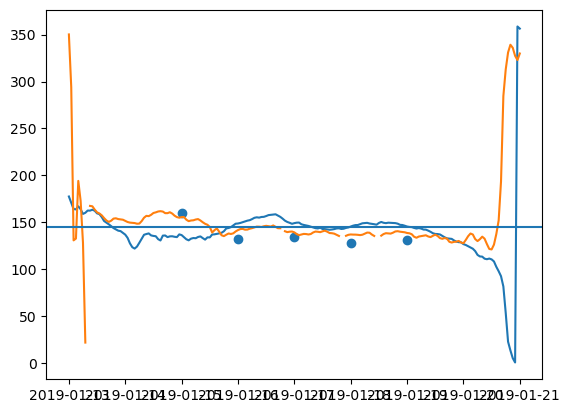

In [495]:
plt.scatter(DS.time[DS.max_length>0], DS.max_length_direction[DS.max_length>0])
plt.plot(dsc_dma.time, current_angle)
plt.plot(dsc_dma.time, ice_angle)

plt.axhline(145)

In [333]:
np.max(X_ip_v2)

<Quantity(26.0944642, 'kilometer')>

In [27]:
25

viirs_times = [datetime(2019,1,14, 11, 35), datetime(2019,1,16, 12, 37), 
               datetime(2019,1,17, 12, 19), datetime(2019,1,18, 12, 0)]
viirs_lengths = np.array([25, 114, 142, 158])


aqua_des_times = [datetime(2019,1,15, 13, 11),datetime(2019,1,16, 12, 15),
                  datetime(2019,1,17, 13, 0), datetime(2019,1,18, 12, 4)]
aqua_des_lengths = np.array([11, 84,141,143])


terra_asc_times = [datetime(2019,1,14, 21, 53),datetime(2019,1,15, 21, 0), datetime(2019,1,16, 21, 41), 
                   datetime(2019,1,17, 20, 45), datetime(2019,1,18, 21, 29)]
terra_asc_lengths = np.array([20,28, 122, 145, 165])

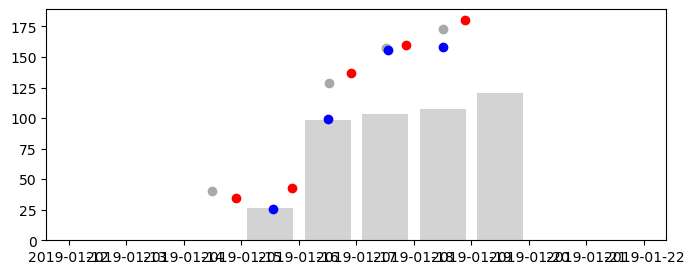

In [199]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(8,3))

ax.bar(pd.to_datetime(DS.time)+timedelta(hours=12), DS.length, color='lightgray', zorder=-1)


offset = 15

ax.scatter(viirs_times, offset+viirs_lengths, color='darkgray', zorder=-1)

ax.scatter(aqua_des_times, offset+aqua_des_lengths, color='b', zorder=-1)
ax.scatter(terra_asc_times, offset+terra_asc_lengths, color='r', zorder=-1)

In [431]:
# daily_t = np.array([])
# daily_v = np.array([])

# for ii in np.arange(0,len(total_T),24):
#     daily_t = np.append(daily_t, np.mean(total_T[ii:ii+24]))
#     daily_v = np.append(daily_v, np.mean(ESE.mean('depth').values[:24*5][ii:ii+24])*units('m/s').to('km/hour'))
    

In [53]:
hourly_flow = current.to('km/hour').magnitude
daily_transport = np.array([np.sum(hourly_flow[ii:ii+24]) for ii in range(len(hourly_flow))])

<IPython.core.display.Javascript object>


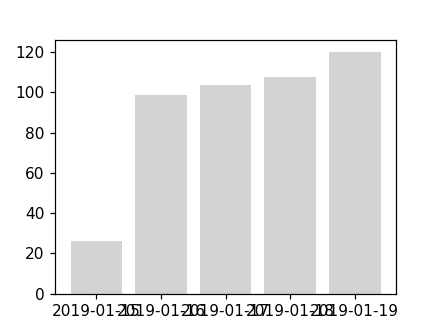

ValueError: operands could not be broadcast together with shapes (217,) (817,) 

In [159]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(4,3))



plt.bar(DS.time, DS.length, color='lightgray', zorder=-1)
plt.plot(dso.time, (current*cooling_time).magnitude)
plt.plot(dso.time, current.to('km/day'), c='b', label='current')
plt.plot(dso.time, icedrift.to('km/day'), c='k', label='current')


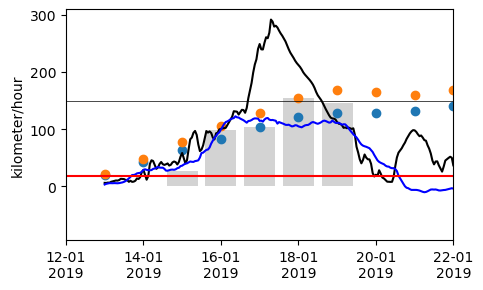

In [58]:
# plt.plot(dso.time[:24*5], total_T)
fig, ax = plt.subplots(figsize=(5,3))

plt.plot(dso.time[:24*18], total_dist, c='k', label='estimated cooling distance')
plt.plot(dso.time, current.to('km/day').magnitude, c='b', label='current')
# plt.plot(dso.time, daily_transport, c='b', label='current')


plt.axhline(18, label='Pease stable length (adjust )', c='r')

plt.bar(DS.time, DS.length.values, color='lightgray', zorder=-1)

# plt.bar(dso.time[:24*5][::24], (daily_v*daily_t), color='r', zorder=-1, alpha=0.5)

plt.xlim(datetime(2019,1,12), datetime(2019,1,22))
# plt.legend(bbox_to_anchor = (1,1))

# plt.scatter(DS.time, np.cumsum(df2[4732:4748].esei.values))
# plt.scatter(DS.time, np.cumsum(df2[4732:4748].ese10.values))

converted_times = pd.to_datetime(df2.time.values)
time_cond = (converted_times >= DS.time.values[0]) & (converted_times <= DS.time.values[-1])

plt.scatter(DS.time, np.cumsum(df2[time_cond].esei.values))
plt.scatter(DS.time, np.cumsum(df2[time_cond].ese10.values))

ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
date_fmt = mdates.DateFormatter('%d-%m\n%Y')
ax.xaxis.set_major_formatter(date_fmt)



plt.axhline(150, c='k', lw=0.5)

In [ ]:
all_max_angles = np.array([])
all_angles = np.array([])


years = [2023, 2024]


for year in years:
    
    with xr.open_dataset(f'../data/polynya_size/daily_polynya_{year}_sic10_v7.1.nc') as ds:
        
        all_max_angles = np.append(all_max_angles, ds.max_length_direction.values[ds.max_length>0])

# ds.max_length.plot(marker='.')
# # ds.max_length_direction.plot()
# ds.l_max.plot(marker='.')

In [1]:
fig, ax = plt.subplots(figsize=(3,3))
plt.hist(all_max_angles, bins=np.arange(0,190,5))
# plt.hist(all_angles, bins=np.arange(0,190,5))


NameError: name 'plt' is not defined

ValueError: x and y must be the same size

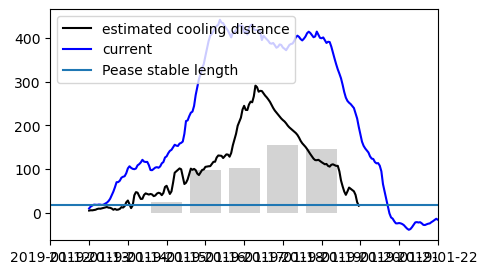

In [116]:
# plt.plot(dso.time[:24*5], total_T)
fig, ax = plt.subplots(figsize=(5,3))

plt.plot(dso.time[:24*7], total_dist, c='k', label='estimated cooling distance')
plt.plot(dso.time, current.to('km/day').magnitude, c='b', label='current')
# plt.plot(dso.time, daily_transport, c='b', label='current')


plt.axhline(18, label='Pease stable length')

plt.bar(DS.time, DS.length, color='lightgray', zorder=-1)

plt.xlim(datetime(2019,1,12), datetime(2019,1,22))
plt.legend()

plt.scatter(DS.time, np.cumsum(df2[4732:4745].esei.values))
plt.scatter(DS.time, np.cumsum(df2[4732:4745].ese10.values))

ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
date_fmt = mdates.DateFormatter('%d-%m\n%Y')
ax.xaxis.set_major_formatter(date_fmt)

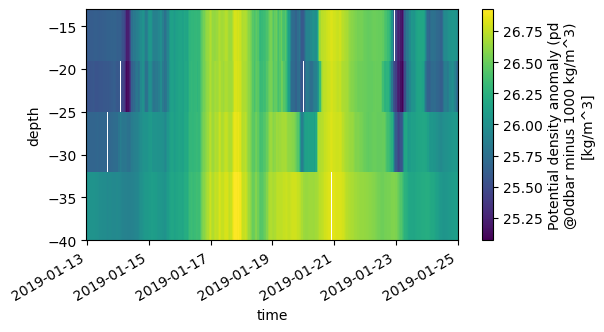

In [795]:
fig, ax = plt.subplots(figsize=(6,3))
dso.sig0.plot()

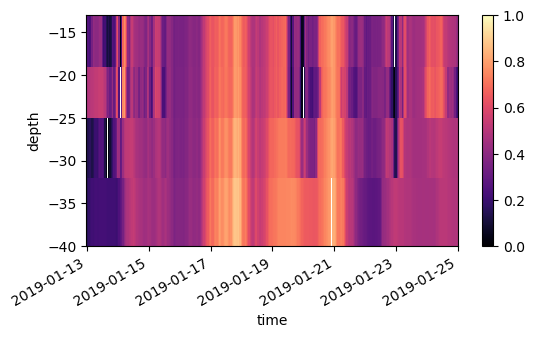

In [840]:
fig, ax = plt.subplots(figsize=(6,3))
# ((dso.Ct - dso.Tf)-(dso.Ct - dso.Tf).sel(depth=-16)).plot(vmin=-0.25, vmax=0.25, cmap='RdBu_r')

((dso.Ct - dso.Tf)).plot(vmin=0, vmax=1, cmap='magma')

In [ ]:
date_fmt = mdates.DateFormatter('%d-%m-%Y')

In [580]:
np.cumsum(df2[4732:4745].esei.values)

array([ 20.99532449,  44.63069102,  63.49488576,  80.84948943,
        99.87842714, 117.82514556, 125.79207366, 125.80374687,
       130.53442653, 141.11425706, 155.13253204, 164.59685351,
       182.25209411])

In [576]:
np.cumsum(df2[4732:4745].esei.values)

array([ 20.46574238,  43.15525686,  63.56465984,  82.93892507,
       102.95725921, 121.00042964, 128.25686123, 128.69426734,
       130.89216318, 140.52581794, 152.51333609, 160.67827094,
       175.88568555])

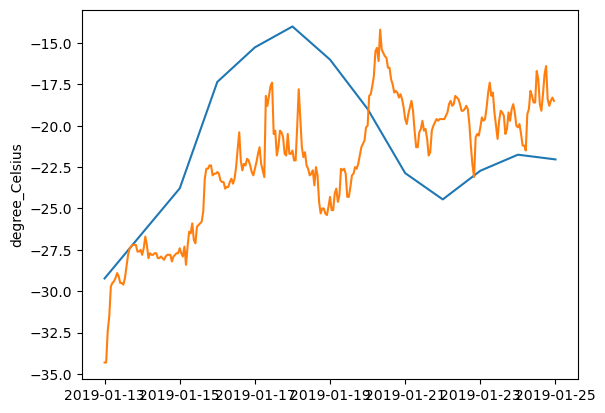

In [443]:
dss = xr.open_dataset('../data/forcing/regional_daily_era_2019_v7_witht2m.nc')
dss = dss.sel(time=time_range)

# plt.plot(dss.time, np.sqrt(dss.u10**2+dss.v10**2))
# plt.plot(dso.time[:-1], Ua)

plt.plot(dss.time, dss.t2m)
plt.plot(dso.time[:-1], Ta)

In [452]:
dsc

<xarray.Dataset>
Dimensions:  (depth: 10, time: 289)
Coordinates:
  * depth    (depth) float64 -30.0 -24.0 -22.0 -18.0 ... -10.0 -8.0 -6.0 -4.0
  * time     (time) datetime64[ns] 2019-01-13 2019-01-13T01:00:00 ... 2019-01-25
Data variables:
    u        (depth, time) float64 -0.02233 -0.02332 ... -0.2566 -0.2468
    v        (depth, time) float64 -0.01361 -0.01187 -0.006635 ... 0.1792 0.1477
Attributes:
    lat:      69.7718
    lon:      -139.2582

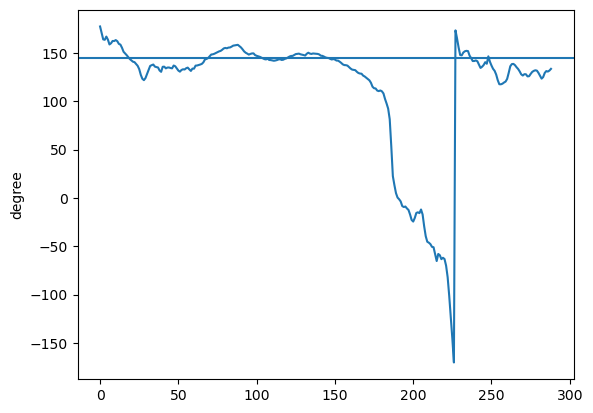

In [451]:
plt.plot(vectors.vector_angle(dsc.u.mean('depth').values, dsc.v.mean('depth').values))

plt.axhline(145)

In [444]:
fig, axs = fn.makemap(view='narrowzoom', contours = [-400,-300,-200,-100], figsize=(4,6), panels=(2,1))

for ax in axs:
    line_kwargs = {'lw':0.75, 'c':[0.6,0.6,0.6]}
    for lat in [69,71,73]:
        ax.plot(np.linspace(-160,-120,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
    for lon in [-160,-150,-140,-130]:
        ax.plot(np.full(100,lon), np.linspace(68,73,100), transform=ccrs.PlateCarree(), **line_kwargs)



NameError: name 'fn' is not defined

In [ ]:
plt.plot(dss.time[:-1], Ua)

In [429]:
len(np.cumsum(df2[4732:4747].esei.values))

15

array(['2019-01-13', '2019-01-14', '2019-01-15', '2019-01-16',
       '2019-01-17', '2019-01-18', '2019-01-19', '2019-01-20',
       '2019-01-21', '2019-01-22', '2019-01-23', '2019-01-24',
       '2019-01-25'], dtype=object)

In [425]:
len(DS.time)

13

In [426]:
np.cumsum(df2[4732:4747].esei.values)

array([ 20.99532449,  44.63069102,  63.49488576,  80.84948943,
        99.87842714, 117.82514556, 125.79207366, 125.80374687,
       130.53442653, 141.11425706, 155.13253204, 164.59685351,
       182.25209411, 195.0465793 , 210.20145829])

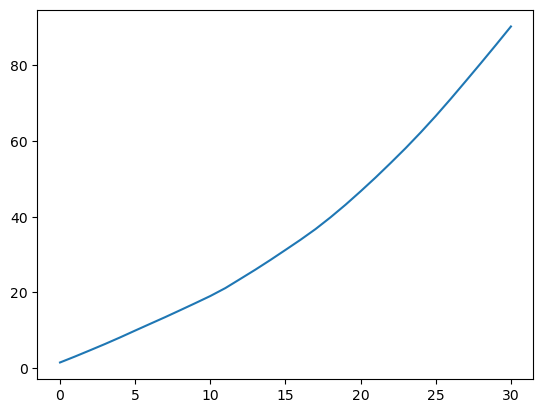

In [320]:
plt.plot(np.cumsum(ESE.mean('depth')[TT:TT+len(all_Tw)]))

In [307]:
dso

<xarray.Dataset>
Dimensions:  (depth: 4, time: 145)
Coordinates:
  * depth    (depth) float64 -36.0 -28.0 -22.0 -16.0
  * time     (time) datetime64[ns] 2019-01-15 2019-01-15T01:00:00 ... 2019-01-21
Data variables:
    T        (depth, time) float64 -1.337 -1.346 -1.359 ... -1.04 -1.037 -1.057
    Sp       (depth, time) float64 32.41 32.43 32.45 32.45 ... 33.36 33.35 33.32
    Sa       (depth, time) float64 32.57 32.59 32.6 32.6 ... 33.52 33.51 33.48
    Ct       (depth, time) float64 -1.33 -1.34 -1.353 ... -1.034 -1.032 -1.051
    Tf       (depth, time) float64 -1.796 -1.797 -1.798 ... -1.835 -1.834 -1.833
    sig0     (depth, time) float64 26.07 26.09 26.1 26.1 ... 26.83 26.82 26.8
Attributes:
    lat:      69.7718
    lon:      -139.2582

In [306]:
len(all_Tw)

31

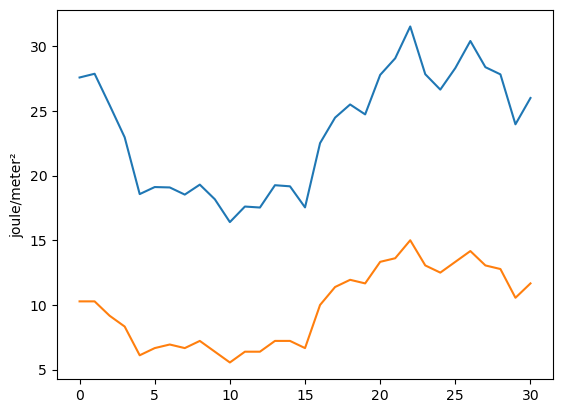

In [305]:
# plt.scatter(np.diff(all_Tw.magnitude), Ua[:12].magnitude)
plt.plot(all_Qn/10e4)
plt.plot(Ua.magnitude[:len(all_Qn)])
# plt.plot(all_hc)

In [279]:
np.diff(all_Tw.magnitude)

array([-0.0174544, -0.0174544, -0.0174544, -0.0174544, -0.0174544,
       -0.0174544, -0.0174544, -0.0174544, -0.0174544, -0.0174544,
       -0.0174544, -0.0174544, -0.0174544, -0.0174544, -0.0174544,
       -0.0174544, -0.0174544, -0.0174544, -0.0174544, -0.0174544,
       -0.0174544, -0.0174544, -0.0174544, -0.0174544])

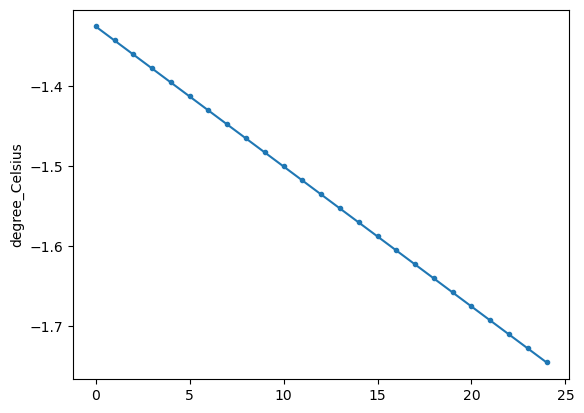

In [282]:
plt.plot(all_Tw, marker='.')

# plt.plot(Ua[:12].magniutde, marker='.')

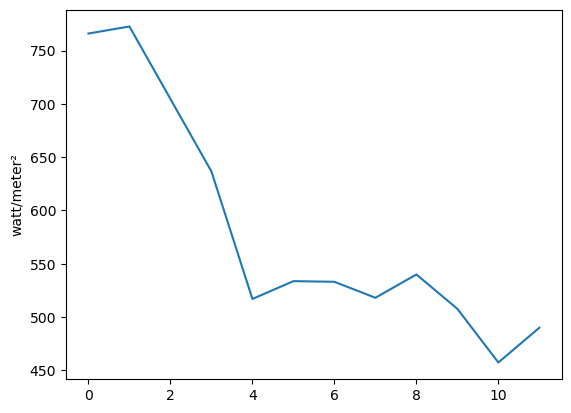

In [257]:
plt.plot(all_Qn)
plt.plot(all_Qn)

<Quantity(-1.30855472, 'degree_Celsius')>

In [214]:
d_ihc_dma = find_change_ihc(sig0_dma[0], dZ, cst)

In [215]:
ihc_dma[0] + d_ihc_dma

<Quantity(69590742.5, 'joule / meter ** 2')>

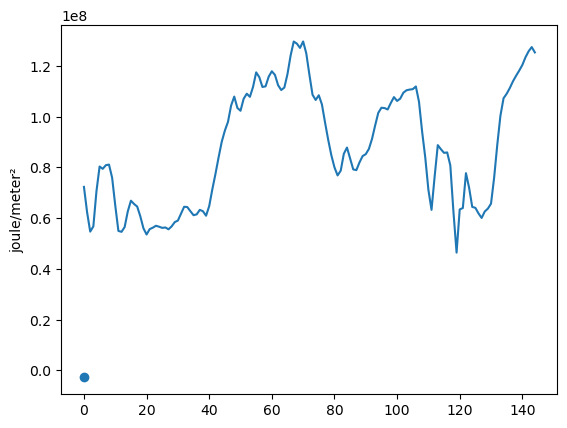

In [202]:
plt.plot(ihc_dma)
plt.scatter(0,d_ihc_dma)

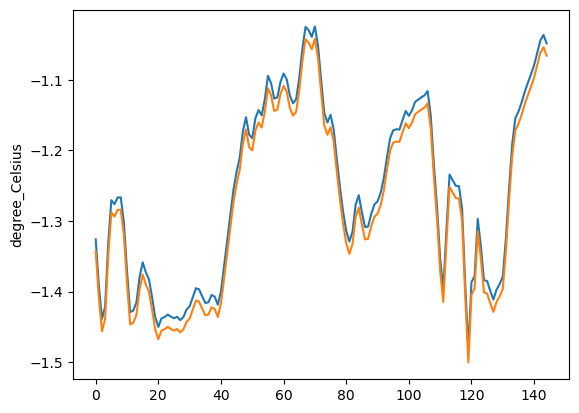

In [195]:
plt.plot(Tw_dma)
plt.plot(Tw_dma+dTi)

In [153]:
dT

<Quantity(0.457882152, 'delta_degree_Celsius')>

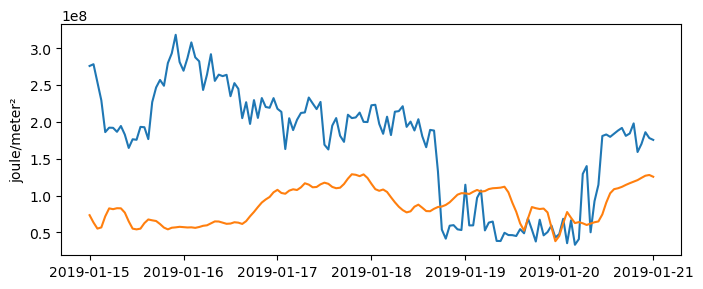

In [151]:
fig, ax = plt.subplots(figsize=(8,3))
plt.plot(dso.time, hourly_dQ*100)
plt.plot(dso.time, IHC_event)
# plt.plot(dso.time, Qs)

In [94]:
hourly_dQ = (dQ * sec_per_hour).to('J/m2')

In [ ]:
Tf = -17.5 * units('')

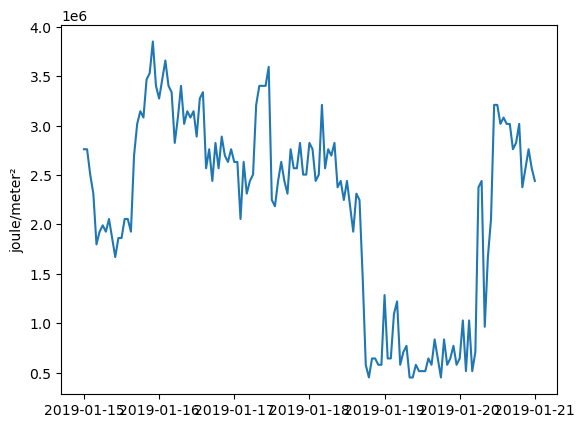

In [95]:
# plt.plot(hc_event.time, hourly_dQ)
# plt.plot(hc_event.time, IHC_event)

plt.plot(hc_event.time, hourly_dQ)
# plt.plot(hc_event.time, IHC_event)

In [80]:
IHC_event

<Quantity([7.34649539e+07 6.35127642e+07 5.52649518e+07 5.68671296e+07
 7.18574338e+07 8.26814118e+07 8.16036356e+07 8.29020265e+07
 8.27477074e+07 7.69479355e+07 6.50982456e+07 5.51889768e+07
 5.42089914e+07 5.52147139e+07 6.26573732e+07 6.76383946e+07
 6.64862488e+07 6.55409525e+07 6.14471977e+07 5.66359248e+07
 5.42292705e+07 5.64403036e+07 5.69512938e+07 5.76727189e+07
 5.72351429e+07 5.67935410e+07 5.69750615e+07 5.62719591e+07
 5.74188183e+07 5.90465284e+07 5.97362231e+07 6.24570185e+07
 6.50093733e+07 6.48712407e+07 6.32955836e+07 6.17495264e+07
 6.21010291e+07 6.38710643e+07 6.33351293e+07 6.15749415e+07
 6.53570908e+07 7.19733549e+07 7.78700390e+07 8.44618522e+07
 9.06161108e+07 9.47946544e+07 9.81783022e+07 1.04484453e+08
 1.07822153e+08 1.03583736e+08 1.02516529e+08 1.06721514e+08
 1.08556769e+08 1.07589131e+08 1.11210589e+08 1.16720603e+08
 1.14920226e+08 1.11295348e+08 1.11690296e+08 1.15284347e+08
 1.17529810e+08 1.15997384e+08 1.11785562e+08 1.10007349e+08
 1.10714119e+08 1.15718626e+08 1.23014843e+08 1.28938283e+08
 1.28230570e+08 1.26387437e+08 1.28770147e+08 1.23935911e+08
 1.16022403e+08 1.08749406e+08 1.06522601e+08 1.08269791e+08
 1.04954137e+08 9.77759372e+07 9.09514516e+07 8.49320062e+07
 8.03277694e+07 7.72283034e+07 7.86816507e+07 8.49586691e+07
 8.77247861e+07 8.35573708e+07 7.90376854e+07 7.88307225e+07
 8.21105412e+07 8.45465404e+07 8.52246673e+07 8.73297353e+07
 9.09414449e+07 9.61618335e+07 1.01255922e+08 1.03286518e+08
 1.03048550e+08 1.02181706e+08 1.05169010e+08 1.07667674e+08
 1.05426662e+08 1.06150635e+08 1.08865733e+08 1.09968719e+08
 1.10309658e+08 1.10802025e+08 1.12028260e+08 1.04488068e+08
 9.04694554e+07 7.81383171e+07 6.22780863e+07 5.25228096e+07
 6.89801041e+07 8.44824783e+07 8.29101601e+07 8.18245609e+07
 8.24304653e+07 7.72036174e+07 5.69332489e+07 3.81886549e+07
 4.52592790e+07 6.24028973e+07 7.77298444e+07 6.99176886e+07
 6.27639368e+07 6.40634843e+07 6.24535631e+07 6.01714236e+07
 6.21170047e+07 6.38814544e+07 6.49637456e+07 7.45107100e+07
 9.04784584e+07 1.03157744e+08 1.08750017e+08 1.09951249e+08
 1.11879873e+08 1.14501811e+08 1.16821863e+08 1.18861005e+08
 1.21006913e+08 1.24081206e+08 1.26972967e+08 1.27969337e+08
 1.25564471e+08], 'joule / meter ** 2')>

In [ ]:
ht_perm3

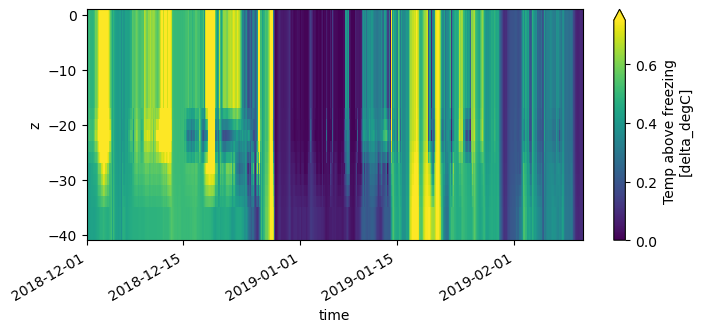

In [18]:
fig, ax= plt.subplots(figsize=(8,3))
ds.dT.plot(vmin=0, vmax=0.75)

In [43]:
Ta[0]

<Quantity(-27.4, 'degree_Celsius')>

In [72]:
=

<Quantity(-1.28455998, 'degree_Celsius')>

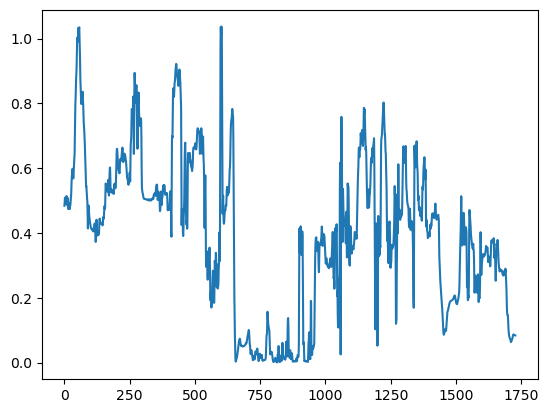

In [31]:
plt.plot(ds.dT.sel(z=0))

In [19]:
dsp = xr.open_dataset(f'../data/forcing/regional_hourly_era_{time_range.stop.year}_v6.nc')
dsp = dsp.sel(time = time_range)

Va = vectors.comp_along_theta(dsp.u10.values, dsp.v10.values, 145*units('degree')) * units('m/s')
Vap = vectors.comp_along_theta(dsp.u10.values, dsp.v10.values, (145-90)*units('degree')) * units('m/s')

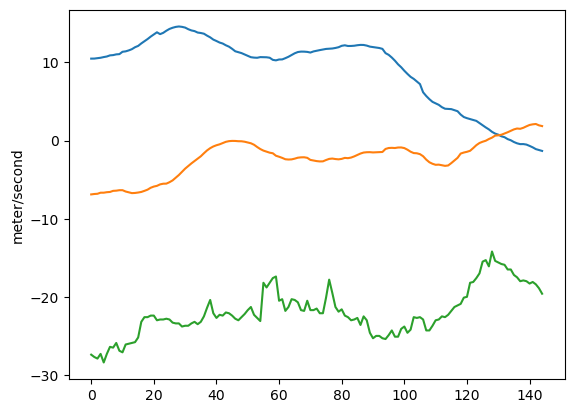

In [20]:
plt.plot(Va)
plt.plot(Vap)
plt.plot(Ta.magnitude)

In [21]:
# polynya length



# Va = 20 * units('m/s')

# Vi = 30 * units('cm/s') # rate of pack ice advection from shore
Vi = 0.035 * Va

Fi = 1 * units('cm/hour') # ice production rate

Hi = 1 * units('m') # frazil ice collection depth

# t = np.arange(0, 360) * units('hour')

t = np.arange(0, len(Vi)) * units('hour')




NameError: name 'Tw' is not defined

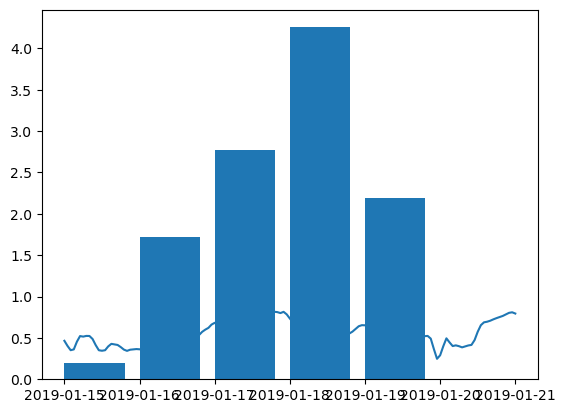

In [22]:
plt.plot(dsp.time, mean_dt.sel(time = time_range))
plt.bar(DS.time, DS.extent/1000, align='edge')
plt.plot(dsp.time, Tw)

In [122]:
Qn = find_dQ(Tw, Ta, Ua)

In [123]:
HC_i - dQ

<Quantity(63335856.5, 'joule / meter ** 2')>

In [134]:
dQ

<Quantity(1800000.0, 'joule / meter ** 2')>

In [54]:
dT = (Twi - Tf).magnitude * units('delta_degC')
DQ = dT * (cst['Cp_o']*sigi) * 40 * units('m')

NameError: name 'Twi' is not defined

In [196]:
(DQ/Qi).to('hour')

<Quantity(36.3455648, 'hour')>

In [171]:
(cst['Cp_o'])

<Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>

In [129]:
dQ/(cst['Cp_o'] * sigi)

<xarray.DataArray 'sig0' ()>
<Quantity(0.455679988, 'delta_degree_Celsius / meter ** 2')>

In [67]:
# initial values
Tf = -1.8 *units('delta_degC')
Twi = np.mean((mean_dt.sel(time = time_range).values+Tf.magnitude)[:12])*units('degC')
sigi = np.mean(mean_sig.sel(time=time_range)[:12]).values * units('kg/m3')
HC_i = np.nanmean(IHC_event[:12])


In [70]:
dt = (1*units('hour').to('s'))
dh = int(dt.to('hour').magnitude)
DZ = 40*units('m')
rho_a = cst['rho_a']


In [80]:
Twi

<Quantity(-1.35244032, 'degree_Celsius')>

In [81]:
Hc = [HC_i]
Tw = [Twi]
# Ua = [np.nanmean(Va[ii*dh:(ii+1)*dh])]
Ua = [Va[0]]
t = [0]

for ii in range(0,32):

    Qt = find_dQ(Tw[-1], Ta[ii], Ua[-1])
    dQ = (Qt * dt).to('J/m2')

    # find cooling rate 
    dTdt = -dQ/((cst['Cp_o']*sigi) * DZ)

    # save new Hc
    Hc.append(Hc[-1] - dQ)
    # save new temp
    Tw.append((Tw[-1].magnitude + dTdt.magnitude) * units('degree_Celsius'))
    # next wind
    Ua.append(np.nanmean(Va[ii*dh:(ii+1)*dh]))
    
    t.append(t[-1] + dt.to('hour').magnitude)

In [87]:
HC_i

<Quantity(70678097.7, 'joule / meter ** 2')>

In [82]:
uu = [U.magnitude for U in Ua]
hhcc = [H.magnitude for H in Hc]
tw = [T.magnitude for T in Tw]

In [83]:
len(t)

33

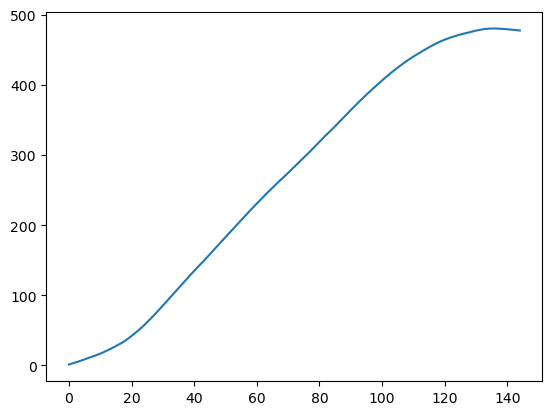

In [84]:
dtt = (((U.sel(time=time_range).time - U.sel(time=time_range).time[0]).values / np.timedelta64(1,'h')))
advection = (np.cumsum(U.sel(time=time_range).mean('z') * 1 * units('hour').to('s'))/1000) * units('km')
plt.plot(dtt, advection)

<>:5: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\c'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_22393/2696151833.py:5: SyntaxWarning: invalid escape sequence '\c'
  ax.set_ylabel('Water parcel T ($^{\circ}$C)', c='b')


Text(0, 0.5, 'Par0cel transport (km)\nalong shelf current')

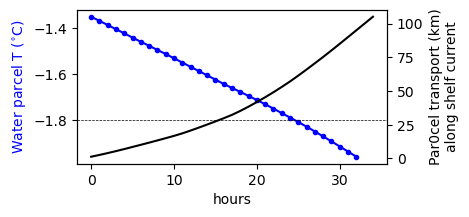

In [86]:
fig, ax = plt.subplots(figsize=(4,2))
# plt.plot(uu)
# plt.plot(t,hhcc)
plt.plot(t, tw, marker='.', c='b')
ax.set_ylabel('Water parcel T ($^{\circ}$C)', c='b')
plt.axhline(Tf, lw=0.5, ls='dashed', c='k')
plt.xlabel('hours')

ax2 = ax.twinx()
ax2.plot(dtt[:35], advection[:35], c='k')
ax2.set_ylabel('Par0cel transport (km)\nalong shelf current')



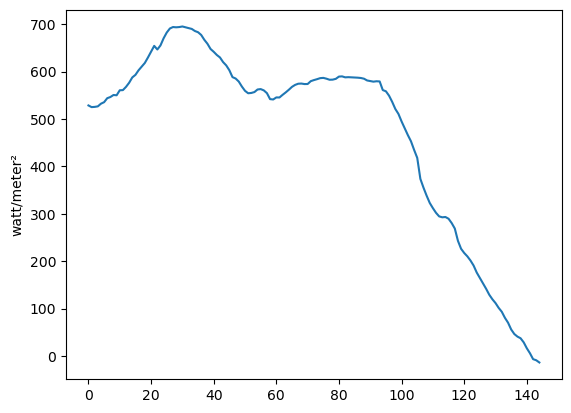

In [93]:
# plt.plot(Qlu+Qld)
# plt.plot(Qs)
plt.plot(Qnet)

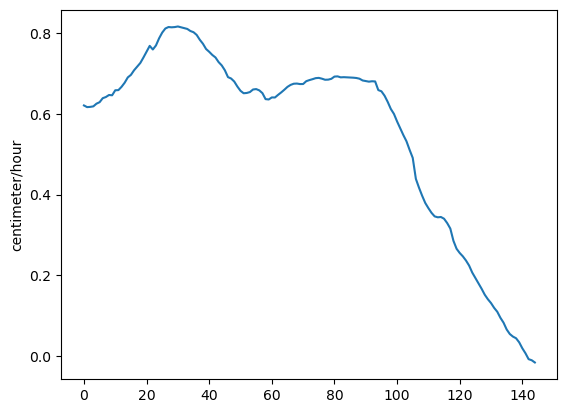

In [80]:

# for now, ignore evaporative latent heat flux, and shortwave radiation for winter

Ta = -17 * units('degC')
rho_a = cst['rho_a']

Tf = -1.8 *units('delta_degC')
Tw = -1.8 * units('degC')



# define positive upward
Qlu = find_Qlu(Tw, cst['sigma_sb'], 0.98)
Qld = -find_Qld(Ta, cst['sigma_sb'], 0.95)
Qs = -find_Qs(Ta, Tw, rho_a, cst['Cp_a'], Va)
# print(Qs)

Qnet = Qlu + Qld + Qs

dHdt = (Qnet / (cst['L_i'] * cst['rho_i'])).to('cm/hour')

plt.plot(dHdt)

<BarContainer object of 193 artists>

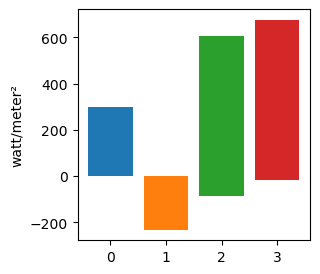

In [48]:
fig, ax = plt.subplots(figsize=(3,3))
plt.bar(0, Qlu)
plt.bar(1, Qld)
plt.bar(2, Qs)
plt.bar(3, Qnet)

In [414]:
# Q = m * C * dT


# dt = 12 *  units('hour')
# rho_o = cst['rho_o']
# H = 16 * units('m')
# dT = (Qnet * dt / (rho_o * H * cst['Cp_o'])).to_base_units()

rho_o = cst['rho_o']
H = 16 * units('m')
dT = (Tw.magnitude * units('delta_degC') - Tf)

(dT * rho_o * H * cst['Cp_o'] / Qnet).to('hour')

# change 

<Quantity([ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0.
 -0.], 'hour')>

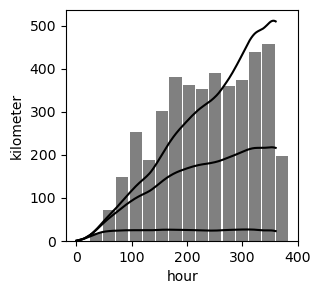

In [415]:
fig, ax= plt.subplots(figsize=(3,3))

plt.bar(DS.t.values, DS.length.values, width=22, align='edge', color='gray')


# X_ip  = xp_over_time_iter(Vi, t, dHdt, Hi = 1 * units('m'))
# X_zip = xp_over_time_iter(Vi, t, np.full(len(dHdt), 0)*units('m/hour'), Hi = 1 * units('m'))

# T = 360 # hours

# Vi = np.full(T, 20*0.03) * units('m/s')
# t = np.arange(T) * units('hour')
# Fi = np.full(T, dHdt) * dHdt.units

Fi = dHdt

X_ip  = xp_over_time_iter(Vi, t, Fi, Hi = 0.1 * units('m'))
X_hip = xp_over_time_iter(Vi, t, 0.1*Fi, Hi = 0.1 * units('m'))
X_zip = xp_over_time_iter(Vi, t, np.full(len(Fi), 0)*units('m/hour'), Hi = 0.1 * units('m'))



# Fi = 0.0001 * units('cm/hour') # ice production rate
plt.plot(t, X_ip, c='k')
plt.plot(t, X_hip, c='k')
plt.plot(t, X_zip, c='k')


In [416]:
np.max(X_ip)

<Quantity(26.1498856, 'kilometer')>

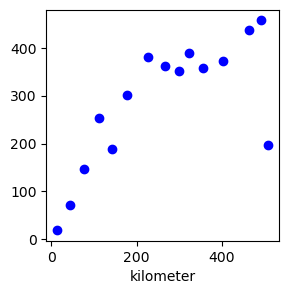

In [407]:
fig,ax=plt.subplots(figsize=(3,3))
# plt.scatter(X_ip[::24], DS.length.values, c='k')
plt.scatter(X_zip[::24], DS.length.values, c='b')


In [380]:
DS

<xarray.Dataset>
Dimensions:               (time: 14, t: 14)
Coordinates:
  * time                  (time) datetime64[ns] 2019-12-07 ... 2019-12-20
  * t                     (t) float64 0.0 24.0 48.0 72.0 ... 264.0 288.0 312.0
Data variables: (12/25)
    N                     (time) float64 ...
    extent                (time) float64 ...
    l_min                 (time) float64 ...
    l_max                 (time) float64 ...
    l_mean                (time) float64 ...
    l_per5                (time) float64 ...
    ...                    ...
    ice_extent            (time) float64 ...
    ocean_extent          (time) float64 ...
    other_polynya_extent  (time) float64 ...
    polynya_extent        (time) float64 ...
    miss_flag             (time) bool ...
    length                (time) float64 nan 20.73 60.69 ... 390.0 62.35 nan

In [267]:
np.nanmax(X_ip)

<Quantity(11.9967615, 'kilometer')>